In [1]:
%matplotlib inline

In [189]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import datetime
from collections import Counter
import math
import copy
import models

import warnings
warnings.filterwarnings('ignore')

<div margin:20px; padding: 20px;">
    <strong>CoNVO</strong>
    <p>Content: Airbnb is an San Francisco-based company operating an online marketplace for short-term homestays and experiences. The company acts as a broker, provides the website, and charges a commission from each booking. Airbnb’s goal is to use historical data, from April 2022 to March 2023, including listings, neighborhood, calendar, reviews to recommend the listing price and listing price adjustment based on the market demand. The final decision makers are the CIO (Airbnb’s Chief Information Officer), and the CMO (Airbnb’s Chief Marketing Officer).</p>
    <p>Need: At the present, Airbnb hosts will manually adjust the listing price based on their own judgement. By learning the market demand and supply, Airbnb will be able to suggest the listing price and the suggest to update a new listing price when needed. From there, the Airbnb hosts will not underprice or overprice their short-term rental properties.</p>
    <p>Vision: All Airbnb hosts will use two features embedded on the production website of Airbnb. The first feature named “Suggested Listing Price” is located next to the “Listing price” box. The second feature is to send an email to the host to suggest the adjustment of the listing price when their listing price is too high or too low.</p>
    <li>Mockup: The final model will predict the market price based on the influence of certain criteria given the last [date range] (for example: the last 4 quarters).</li>
    <li>Argument sketch: “Based on the last 4 quarters of historical listings, the listing price of a 1 bed 1 bath property in your area is 10% higher in the month of March and April. Hence, to increase yours and maximize your profits, you are suggested adjusting your listing price from $150 per night to $160 - $170$ per night.”</li>
    <p>Outcome: First, the CIO and the CMO will be able to test and view two features embedded on the testing website of Airbnb under the Washington DC region only. The testing period will be 6 months before the new model is put into production but only in the Washington DC region. During the testing time, the CIO, the CMO and the data team will monitor closely the performance of the new model. The evaluation of this new algorithm on production will be conducted after each quarter for the first 2 years. If the result comes out well, the new model will be applied to all other regions. From there, the evaluation will be examined every 2 quarters. Periodic updates to the system will be needed but its frequency will be dependent on the results and as bugs are reported.
</p>
</div>

<p>Our question is that given certain factors of the property, can we suggest the price per night of that airbnb property which is as high accuracy as similar properties on the market? Based on this question, our target variable is Price.</p>

<p>During exploring variables singly and pairwise, we found some interesting and important variables. Regarding the place, they are beds, bedrooms, bathrooms, accommodates, room types. Regarding the host, they are host acceptance rate, host response rate, host is superhost, and host identity verified. Regarding the review, some reviews seems more significant than others, such as review scores cleanliness, and review scores location. Regarding the location, as we mentioned in README, we used the latitude and longitude of some famous attractions in Washington DC combined with the latitude and longitude given in the dataset to measure the distance between the listing property and each attraction. We found out that attractions have certain influences on the model.</p>

<p> Below are EDA on some variables. For the full EDA, please review eda.ipynb.

In [3]:
# Connect to airbnb database
connection = sqlite3.connect('airbnb.db')

In [4]:
# Query the listings table in airbnb.db and convert the listings table to dataframe
vwListings = pd.read_sql('SELECT * FROM most_recent_listings', connection)
vwListings1 = pd.read_sql('SELECT * FROM most_recent_listings', connection)

### Price

`price` is the main variable of interest. It indicates the unit price (price per night) of an Airbnb property. We would expect this variable may fit Gaussian distribution. We will need to convert this variable to numeric before performing an EDA.

In [5]:
vwListings['price'] = vwListings['price'].str.lstrip('$')
vwListings['price'] = vwListings['price'].str.replace(",", "")
vwListings['price'] = pd.to_numeric(vwListings['price'])

In [6]:
vwListings.price.describe()

count    8628.000000
mean      181.288711
std       224.678136
min         0.000000
25%        85.000000
50%       131.000000
75%       207.000000
max      7500.000000
Name: price, dtype: float64

The mean price per night is 181 dollars per night. The minimum and the maximum unit price are 0 dollars and 7,500 dollars per night respectively. The 1st, 2nd and 3rd quartile are 85 dollars, 131 dollars and 207 dollars respectively. Because the mean price is higher than the median price, we would expect to have a right skewed distribution.

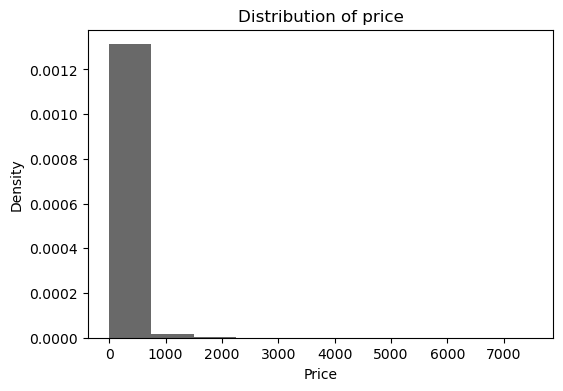

In [7]:
figure = plt.figure(figsize=(6, 4))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.price, density = True, color="dimgray")
axes.set_title("Distribution of price")
axes.set_xlabel("Price")
axes.set_ylabel("Density")

plt.show()
plt.close()

In [8]:
def freeman_diaconis( data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int( h)

Freeman Diaconis:  11


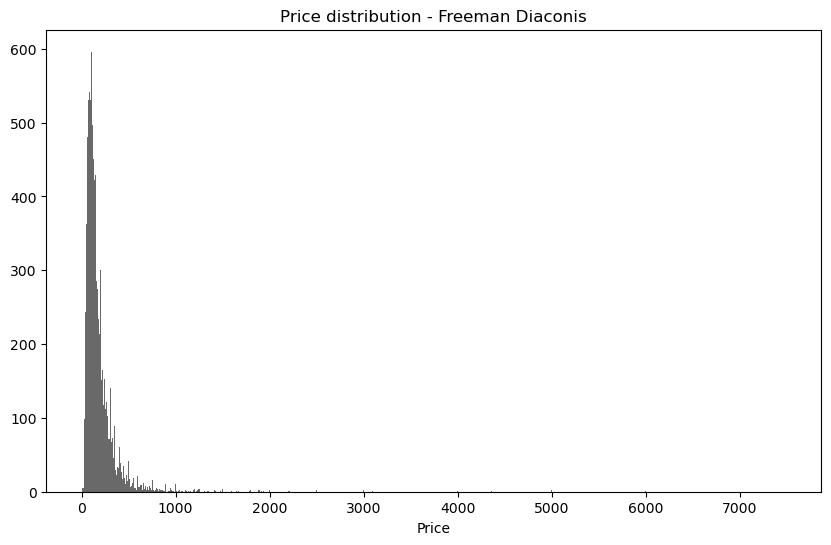

In [9]:
h = freeman_diaconis(vwListings.price)
print("Freeman Diaconis: ", h)
mn = int(vwListings.price.min())
mx = int(vwListings.price.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.price,bins=bins, color="DimGray")
axes.set_title("Price distribution - Freeman Diaconis")
axes.set_xlabel("Price")

plt.show()
plt.close()

As we expected, the distribution is positively skewed. This variable may fit Gaussian distribution. The majority of the price is under 500 dollars per night. It is so rare to have the price over 1,000 dollars per night. 

### Host response time

`host_response_time` is a categorical variable which represents the response time of the host. According to Airbnb, the response time is the average time it took the host to respond to any messages over the last 30 days. We are not sure how many unique values in this variable. However, we expect the majority of the hosts will response within an hour or two.

In [10]:
vwListings.host_response_time

0                      N/A
1       within a few hours
2           within an hour
3           within an hour
4                      N/A
               ...        
8623        within an hour
8624    within a few hours
8625                   N/A
8626        within an hour
8627                   N/A
Name: host_response_time, Length: 8628, dtype: object

In [11]:
percent = vwListings.host_response_time.value_counts(normalize=True)
percent

within an hour        0.623899
N/A                   0.170723
within a few hours    0.127376
within a day          0.065137
a few days or more    0.010547
                      0.002318
Name: host_response_time, dtype: float64

It looks like there are 4 different unique values here and 0.02% of total number of records are null. The interesting thing here is that we do not know whether "N/A" and null value are the same meaning or different. However, we will create the bar chart to reflect the difference between each value. Because this variable is ordinal variable. The order from shortest to longest is "within an hour", "within a few hours", "within a day", "a few days or more". By that order, we expect the data may fit Gamma distribution.

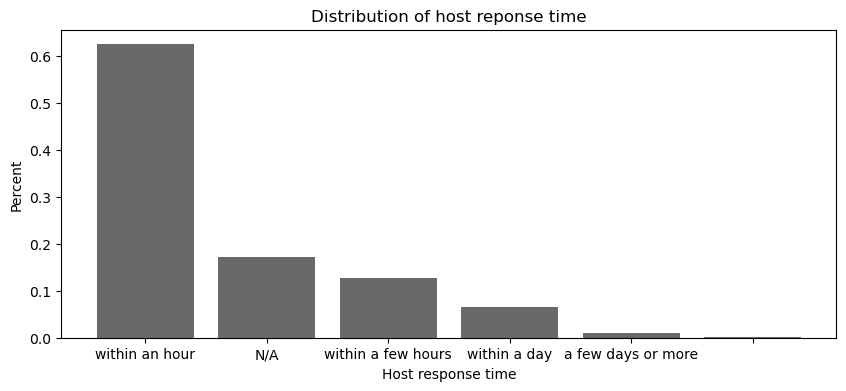

In [12]:
percent = vwListings.host_response_time.value_counts(normalize=True)
response_time = ["within an hour", "N/A", "within a few hours", "within a day", "a few days or more" , " "]

figure = plt.figure(figsize=(10, 4))
axes = figure.add_subplot(1, 1, 1)
axes.bar(response_time, percent, align="center", color="dimgray")
axes.set_xticklabels(percent.axes[0])
axes.set_title("Distribution of host reponse time")
axes.set_xlabel("Host response time")
axes.set_ylabel("Percent")

plt.show()
plt.close()

As we expected, most of the hosts responded within an hour (over 60%). Besides, N/A, some hosts responded within a few hour (around 18%). It is rare to see the hosts responded a few days or more. In other words, in this view, the majority of the hosts are pretty responsive.

### Host response rate

`host_response_rate` seems like a numeric variable. According to Airbnb, host response rate reflects the percentage of booking requests and enquiries the host has responded to within 24 hours over the past 30 days. Host response rate is most important, as it affects where the property ranks in search results and also impacts host superhost status. 

In [13]:
vwListings.host_response_rate

0        N/A
1       100%
2       100%
3       100%
4        N/A
        ... 
8623     70%
8624    100%
8625     N/A
8626     92%
8627     N/A
Name: host_response_rate, Length: 8628, dtype: object

This variable contains some N/A records. Let's see how many N/A records are there.

In [14]:
na_counts = 0
for i in range(len(vwListings.host_response_rate)):
    if vwListings['host_response_rate'][i] == 'N/A':
        na_counts += 1
    else:
        continue
        
print(f"In {len(vwListings.host_response_rate)} records, there are {na_counts} records with N/A host response rate in this view.")

In 8628 records, there are 1473 records with N/A host response rate in this view.


We will exclude 1473 N/A records for now. Excluding all N/A values, we hypothesize this variable may fit Gamma distribution if the host response rate is descending.

 

In [15]:
response_rate = []
for i in range(len(vwListings.host_response_rate)):
    if vwListings['host_response_rate'][i] != 'N/A':
        vwListings['host_response_rate'][i] = vwListings['host_response_rate'][i].replace('%', '')
        vwListings['host_response_rate'][i] = pd.to_numeric(vwListings['host_response_rate'][i])
        response_rate.append(pd.to_numeric(vwListings['host_response_rate'][i]))
    else:
        continue

In [16]:
response_rate_df = pd.DataFrame(response_rate)
response_rate_df.describe()

,0
count,7135.000000
mean,96.885774
std,11.191166
min,0.000000
25%,100.000000
50%,100.000000
75%,100.000000
max,100.000000


The mean host response rate is 96%. The minimum and the maximum host response rate are 0% and 100% respectively. Based on the statistics above, if the host response rate is descending, the data possibly fit Gamma distribution.

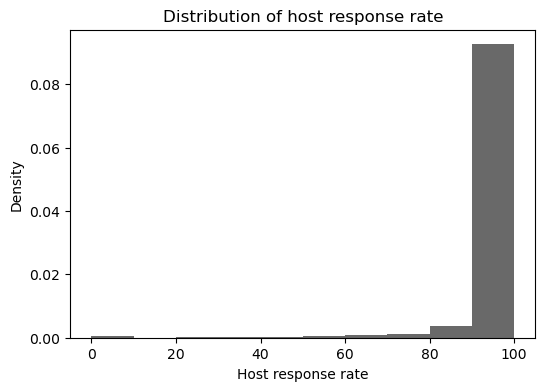

In [17]:
figure = plt.figure(figsize=(6, 4))

axes = figure.add_subplot(1, 1, 1)
axes.hist(response_rate, density = True, color="dimgray")
axes.set_title("Distribution of host response rate")
axes.set_xlabel("Host response rate")
axes.set_ylabel("Density")

plt.show()
plt.close()

Around 95% of the host response rate are 90% and above. It means that the host is pretty responsive, similar to what we explored in the `host_response_time`.

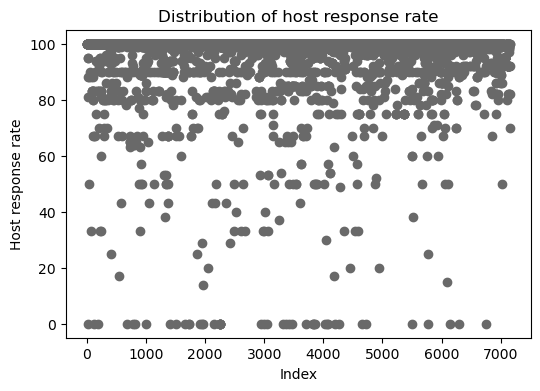

In [18]:
figure = plt.figure(figsize=(6, 4))

axes = figure.add_subplot(1, 1, 1)
axes.plot(response_rate, 'o', color="dimgray")
axes.set_title("Distribution of host response rate")
axes.set_xlabel("Index")
axes.set_ylabel("Host response rate")

plt.show()
plt.close()

This plot obviously showed that the majority of the listings have the high responsive host. The host response rate is 80% and above. However, there are some listings that the host is not responsive at all, 0%. It's kinda strange to see that there are some hosts have 0% response rate. We will check how many of them.

In [19]:
count = (vwListings['host_response_rate'] == 0).sum()

print(f"There are {count} listings having 0% host response rate.")

There are 46 listings having 0% host response rate.


We would like to see if those hosts have an available Airbnb properties.

In [20]:
count = ((vwListings['host_response_rate'] == 0) & (vwListings['has_availability'] == 't')).sum()
print(f"All {count} hosts having 0% response rate actually still have an unavailable Airbnb property.")

All 46 hosts having 0% response rate actually still have an unavailable Airbnb property.


### Host acceptance rate

`host_acceptance_rate` is the boolean variable. Host acceptance rate measures how often the host accepts or decline reservations. Guest inquiries are not included in the calculation of host acceptance rate.

In [21]:
vwListings.host_acceptance_rate

0        N/A
1       100%
2        82%
3        96%
4        62%
        ... 
8623     39%
8624     76%
8625     N/A
8626    100%
8627     N/A
Name: host_acceptance_rate, Length: 8628, dtype: object

Similar to `host_response_rate`, `host_acceptance_rate` consists of some N/A values. We will count how many N/A values in this variable.

In [22]:
na_counts = 0
for i in range(len(vwListings.host_acceptance_rate)):
    if vwListings['host_acceptance_rate'][i] == 'N/A':
        na_counts += 1
    else:
        continue
        
print(f"In {len(vwListings.host_acceptance_rate)} records, there are {na_counts} records with N/A host acceptance rate in this view.")

In 8628 records, there are 1073 records with N/A host acceptance rate in this view.


Compared to `host_response_rate`, `host_acceptance_rate` has fewer N/A values. We will temporarily exclude these N/A values for now.

In [23]:
acceptance_rate = []
for i in range(len(vwListings.host_acceptance_rate)):
    if vwListings['host_acceptance_rate'][i] != 'N/A':
        vwListings['host_acceptance_rate'][i] = vwListings['host_acceptance_rate'][i].replace('%', '')
        vwListings['host_acceptance_rate'][i] = pd.to_numeric(vwListings['host_acceptance_rate'][i])
        acceptance_rate.append(pd.to_numeric(vwListings['host_acceptance_rate'][i]))
    else:
        continue

In [24]:
acceptance_rate_df = pd.DataFrame(acceptance_rate)
acceptance_rate_df.describe()

,0
count,7535.000000
mean,88.742004
std,20.211526
min,0.000000
25%,89.000000
50%,97.000000
75%,100.000000
max,100.000000


The mean acceptance rate is 88% while the median acceptance rate is 97%. The minimum and the maximum acceptance rate are 0% and 100%. Let's see how many listings having 0% acceptance rate.

In [25]:
count = (vwListings['host_acceptance_rate'] == 0).sum()

print(f"There are {count} listings having 0% host acceptance rate.")

There are 101 listings having 0% host acceptance rate.


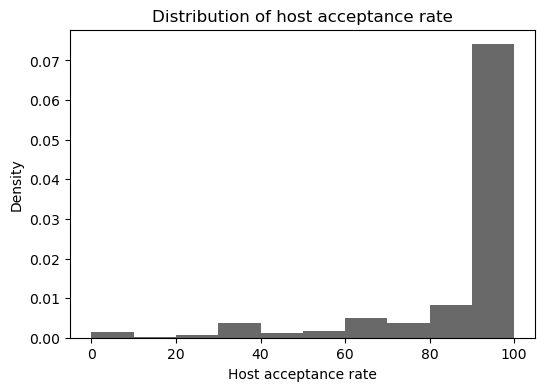

In [26]:
figure = plt.figure(figsize=(6, 4))

axes = figure.add_subplot(1, 1, 1)
axes.hist(acceptance_rate, density = True, color="dimgray")
axes.set_title("Distribution of host acceptance rate")
axes.set_xlabel("Host acceptance rate")
axes.set_ylabel("Density")

plt.show()
plt.close()

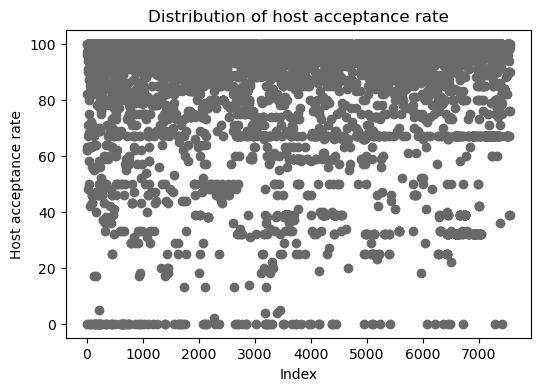

In [27]:
figure = plt.figure(figsize=(6, 4))

axes = figure.add_subplot(1, 1, 1)
axes.plot(acceptance_rate, 'o', color="dimgray")
axes.set_title("Distribution of host acceptance rate")
axes.set_xlabel("Index")
axes.set_ylabel("Host acceptance rate")

plt.show()
plt.close()

The majority of the hosts have a high acceptance rate, around 80% and above. However, we still see some hosts are pretty picky. Their acceptance rate can be as low as 5% (beside 0%).

### Host is superhost

`host_is_superhost` is the boolean variable. It indicates whether the host is superhost. According to Airbnb, to become an superhost, the host has to be qualified as follows:
1. Completed at least 10 trips or 3 reservations that total at least 100 nights
2. Maintained a 90% response rate or higher
3. Maintained a less than 1% cancellation rate, with exceptions made for those that fall under our Extenuating Circumstances policy
4. Maintained a 4.8 overall rating (A review counts towards Superhost status when either both the guest and the Host have submitted a review, or the 14-day window for reviews is over, whichever comes first).

In [28]:
count = vwListings['host_is_superhost'].value_counts(normalize=True)
count

f    0.716852
t    0.282684
     0.000464
Name: host_is_superhost, dtype: float64

It looks like this variable also contains 0.04% null values. We will ignore these null values for now.

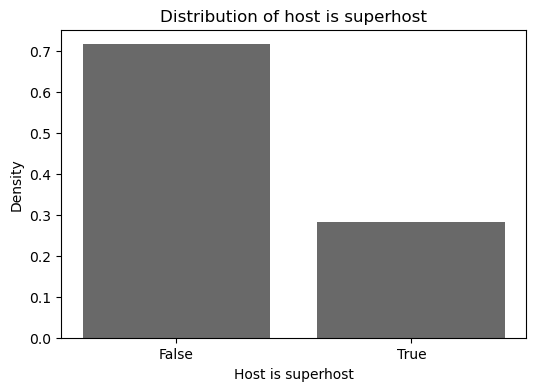

In [29]:
x = ['False', 'True']
y = [count[0], count[1]]

figure = plt.figure(figsize=(6, 4))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, y, color="dimgray")
axes.set_title("Distribution of host is superhost")
axes.set_xlabel("Host is superhost")
axes.set_ylabel("Density")

plt.show()
plt.close()

In this view, there are more not-a-superhost than superhost. Not-a-superhost is approximately 3 times higher than a superhost.

### Host identity verified

`host_identity_verified` is another boolean variable. It indicates whether the host identity is verified by Airbnb.

In [30]:
count = vwListings.host_identity_verified.value_counts(normalize=True)
count

t    0.874478
f    0.123204
     0.002318
Name: host_identity_verified, dtype: float64

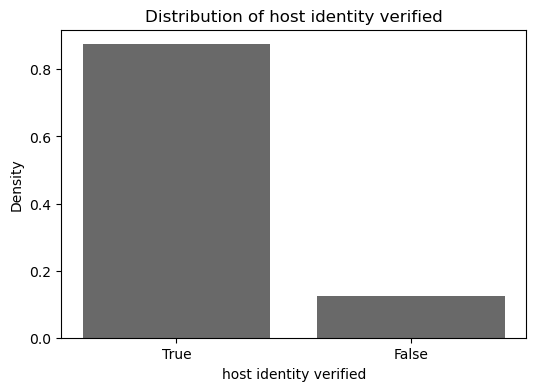

In [31]:
x = ['True', 'False']
y = [count[0], count[1]]

figure = plt.figure(figsize=(6, 4))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, y, color="dimgray")
axes.set_title("Distribution of host identity verified")
axes.set_xlabel("host identity verified")
axes.set_ylabel("Density")

plt.show()
plt.close()

There are more hosts with their identity verified than the hosts who have not, 87% versus 12%.

### Room type

In [32]:
rt = vwListings['room_type']

We first look at a description of <b><i>room_type</i></b>:

In [33]:
pd.DataFrame(rt.describe())

,room_type
count,8628
unique,4
top,Entire home/apt
freq,6455


There are only 4 room types. We display the value counts:

In [34]:
pd.DataFrame(rt.value_counts(normalize=True))

,room_type
Entire home/apt,0.748146
Private room,0.235049
Shared room,0.014256
Hotel room,0.002550


"Entire home/apt" is by far the most common value, comprising 74.8% of the data. "Private room" is next, with 23.5% of the data. "Shared room" and "Hotel room" are pretty rare, with 1.4% and 0.2% of the data, respectively. These groups map on pretty well to the groups that were found in property_type, though the Other category has been distributed among the rest.

There does appear to be a problem, though. 1.1% of the listings have property_type = 'Room in hotel', yet only 0.3% of the listings have room_type = 'Hotel room'. This is likely due to mistakes in room_type, but we will revisit this issue in pairwise EDA.

### Accommodates

Accommodates describes the number of people that an Airbnb can accommodate. In other words this is the maximum capacity of the listing. This is a ordered numerical variable and would lead us to believe that it would affect the listing's price. The more a listing can accommodate, the higher the price of the Airbnb due to factors such as size, resources provided, and number of guests who can split the price of the Airbnb.

In [35]:
tempDF = vwListings
tempDF["accommodates"].replace('', np.nan, inplace=True)
tempDF.dropna(subset=['accommodates'], inplace=True)

In [36]:
tempDF["accommodates"].describe()

count    8628.000000
mean        3.632592
std         2.389346
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        16.000000
Name: accommodates, dtype: float64

In [37]:
tempDF["accommodates"].value_counts().sort_index()

0        4
1      902
2     2734
3     1091
4     1837
5      588
6      724
7      121
8      292
9       41
10     119
11      15
12      82
13      10
14      17
15       8
16      43
Name: accommodates, dtype: int64

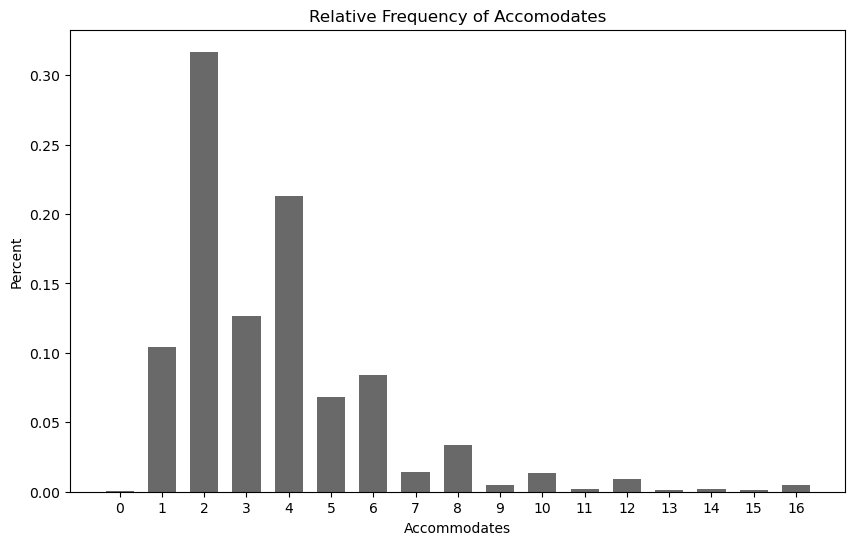

In [38]:
counts = tempDF["accommodates"].value_counts().sort_index()
proportions = tempDF["accommodates"].value_counts(normalize=True).sort_index()
x = range( len( counts))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, proportions, width, color="dimgray", align="center")
axes.set_xlabel("Accommodates")
axes.set_xticks(x)
axes.set_xticklabels(proportions.axes[0])
axes.set_title( "Relative Frequency of Accomodates")
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

### Bathrooms text

Bathrooms_text corresponds to the number of bathrooms in an Airbnb listing. It is a string type variable which makes it a categorical variable. For our analysis we extracted the number of bathrooms and made it a numerical variable in the bathroom_numbers column via a regular expression. Domain knowledge would lead us to believe that more bathrooms would positively affect the price of a listing. As opposed to being less bathrooms which would lead the price to be less.

In [39]:
tempDF = vwListings
tempDF["bathrooms_text"].replace('', np.nan, inplace=True)
tempDF.dropna(subset=['bathrooms_text'], inplace=True)

In [40]:
tempDF['bathroom_numbers'] = tempDF['bathrooms_text'].str.extract('(\d+)')

In [41]:
tempDF["bathroom_numbers"].describe()

count     8617
unique      11
top          1
freq      6419
Name: bathroom_numbers, dtype: object

In [42]:
pd.DataFrame(tempDF["bathroom_numbers"].value_counts())

,bathroom_numbers
1,6419
2,1487
3,387
0,189
4,93
5,24
6,12
11,2
7,2
8,1


Overall, most listings have only 1 bathroom while the next most have only 2 bathrooms. The third most listings have 1 shared bath followed by listings with 2.5 baths. There are outlier values such as 11 shared baths, 0 baths, and 15 baths in an Airbnb listing.

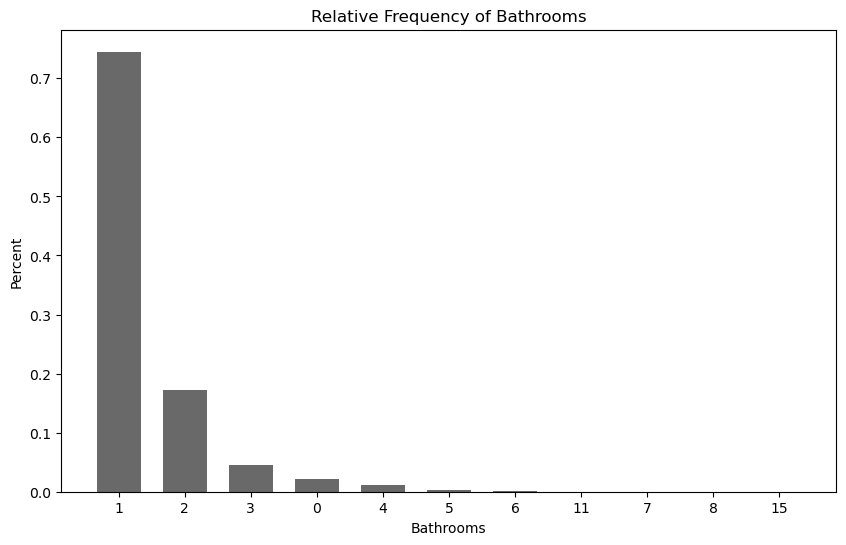

In [43]:
counts = tempDF["bathroom_numbers"].value_counts().sort_index()
proportions = tempDF["bathroom_numbers"].value_counts(normalize=True)
x = range( len( counts))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, proportions, width, color="dimgray", align="center")
axes.set_xlabel("Bathrooms")
axes.set_xticks(x)
axes.set_xticklabels(proportions.axes[0])
axes.set_title( "Relative Frequency of Bathrooms")
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

### Bedrooms

bedrooms is a numerical variable that corresponds to the number of bedrooms in an Airbnb listing. It is a key feature of an Airbnb and based on our domain knowledge would suggest that it significant affects the price of it. With more bedrooms, the price of the Airbnb listing would increase.

In [44]:
tempDF = vwListings
tempDF["bedrooms"].replace('', np.nan, inplace=True)
tempDF.dropna(subset=['bedrooms'], inplace=True)

In [45]:
tempDF["bedrooms"].describe()

count    7880.000000
mean        1.659898
std         1.082609
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        15.000000
Name: bedrooms, dtype: float64

When we look at the descriptive statistics of number of bedrooms in an Airbnb listing, the first thing we notice is that the extreme maximum value of 15 bedrooms is much more extreme than most of the distribution of bedrooms. Each Airbnb has at least 1 bedroom but the majority of listings in the Airbnb data contain only 1 to 2 bedrooms, given that the 75% quartile is 2 bedrooms. The mean number of bedrooms is 1.65 and the median is one bedroom.

In [46]:
tempDF["bedrooms"].value_counts().sort_index()

1.0     4895
2.0     1693
3.0      726
4.0      345
5.0      136
6.0       55
7.0       18
8.0        9
9.0        2
15.0       1
Name: bedrooms, dtype: int64

Taking a look at the value counts, only one listing has 15 bedrooms while 1 listing has 9 bedrooms. A majority of listings have 1 and 2 bedrooms which correspond to the descriptive statistics. Additionally, there are a sizeable number of Airbnb listings with 3-5 bedrooms with 429, 218 and 84 listings respectively with these number of bedrooms.

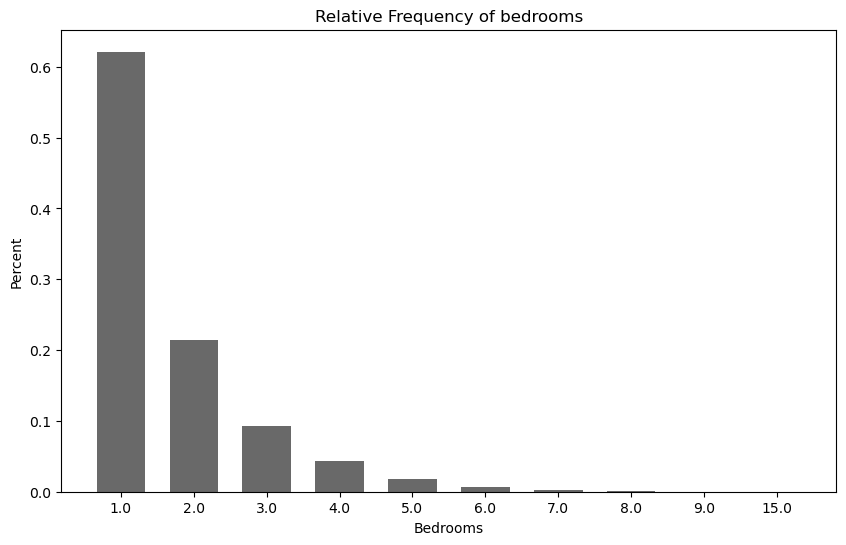

In [47]:
counts = tempDF["bedrooms"].value_counts().sort_index()
proportions = tempDF["bedrooms"].value_counts(normalize=True).sort_index()
x = range( len( counts))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, proportions, width, color="dimgray", align="center")
axes.set_xlabel("Bedrooms")
axes.set_xticks(x)
axes.set_xticklabels(proportions.axes[0])
axes.set_title( "Relative Frequency of bedrooms")
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

### Beds

Beds corresponds to the number of beds in an Airbnb listing. This column is not the same as bedrooms due to the fact that a bed or futon could be classified as a bed which means there could be beds not in a bedroom. Additionally there could be more than one bed in a bedroom. Domain knowledge would lead us to believe that more beds would demand higher prices which is the same intuition as bedrooms and accommodates.

In [48]:
tempDF = vwListings
tempDF["beds"].replace('', np.nan, inplace=True)
tempDF.dropna(subset=['beds'], inplace=True)

In [49]:
tempDF["beds"].describe()

count    7789.000000
mean        2.023495
std         1.418597
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        20.000000
Name: beds, dtype: float64

In [50]:
tempDF["beds"].value_counts().sort_index()

1.0     3643
2.0     2250
3.0      978
4.0      441
5.0      206
6.0      156
7.0       45
8.0       41
9.0       10
10.0       6
11.0       3
12.0       9
20.0       1
Name: beds, dtype: int64

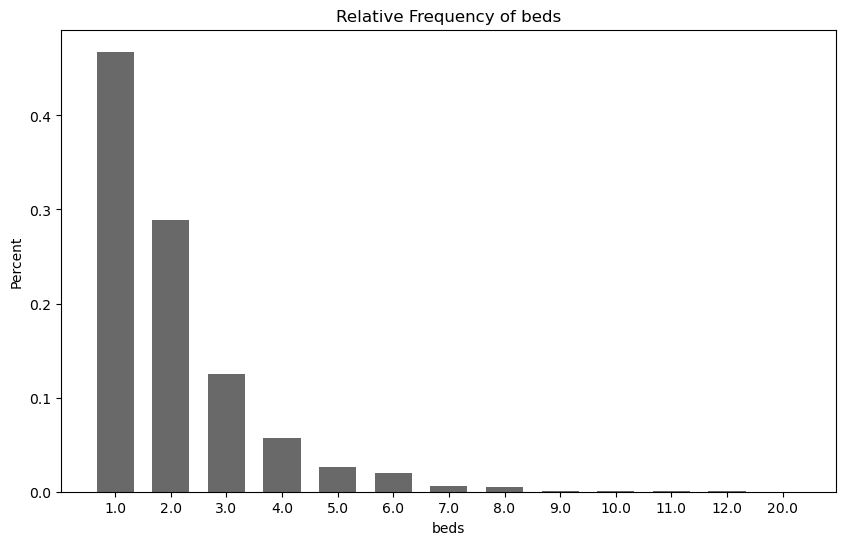

In [51]:
counts = tempDF["beds"].value_counts().sort_index()
proportions = tempDF["beds"].value_counts(normalize=True).sort_index()
x = range( len( counts))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, proportions, width, color="dimgray", align="center")
axes.set_xlabel("beds")
axes.set_xticks(x)
axes.set_xticklabels(proportions.axes[0])
axes.set_title( "Relative Frequency of beds")
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

### Number of reviews 

Number of review is the number of reviews that listing has. It is the integer number.

In [52]:
vwListings.number_of_reviews.describe()

count    7789.000000
mean       42.938760
std        78.983663
min         0.000000
25%         0.000000
50%         9.000000
75%        48.000000
max       898.000000
Name: number_of_reviews, dtype: float64

The variable distribution is skewed. The mean number of reviews is 45 times, and the median is 10 pounds, or about 78% lower. The 3rd quartile is 51, around 51x the 1st quartile. The minimum is "only" 0, while the maximum is 898.

In [53]:
vwListings.number_of_reviews.value_counts()

0      2038
1       512
2       301
3       225
4       190
       ... 
474       1
242       1
315       1
459       1
311       1
Name: number_of_reviews, Length: 411, dtype: int64

Let's plot a histogram of the data:

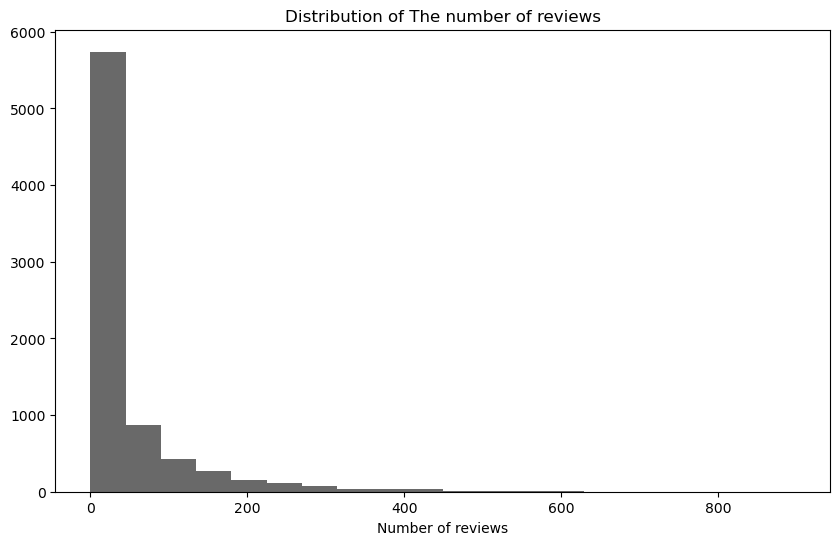

In [54]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.number_of_reviews, color="dimgray", bins = 20)
axes.set_title("Distribution of The number of reviews")
axes.set_xlabel("Number of reviews")

plt.show()
plt.close()

No surprise, the most number of reviews is not reviews. It is not normally distributed. 

### Review scores

There are 7 types of review scores left by guests. review_scores_rating is the overall rating of the experience. review_scores_accuracy rates how accurate the information provided by the host was. review_scores_cleanliness is self-explanatory, rating how clean the rental was. review_scores_checkin rates how easy the host made the check-in process. review_scores_communication rates how well the host communicated with the guests. review_scores_location is also self-explanatory, rating the location of the rental. Finally, review_scores_value rates how well the guest felt they got their money's worth.

We replace blank review values with NaN for now.

In [55]:
vwListings[['review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
     'review_scores_communication','review_scores_location','review_scores_value']] = vwListings[[
    'review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
     'review_scores_communication','review_scores_location','review_scores_value']].replace('', np.NaN)

We display descriptive statistics for each review score.

In [56]:
vwListings[['review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin']].describe()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin
count,5751.000000,5729.000000,5729.000000,5729.000000
mean,4.707793,4.786048,4.735998,4.844835
std,0.508186,0.388080,0.412624,0.347933
min,0.000000,1.000000,1.000000,1.000000
25%,4.650000,4.750000,4.670000,4.850000
50%,4.840000,4.900000,4.870000,4.950000
75%,4.960000,5.000000,4.990000,5.000000
max,5.000000,5.000000,5.000000,5.000000


In [57]:
vwListings[['review_scores_communication','review_scores_location','review_scores_value']].describe()

,review_scores_communication,review_scores_location,review_scores_value
count,5729.000000,5729.000000,5728.000000
mean,4.830236,4.757631,4.681952
std,0.372834,0.383897,0.427388
min,1.000000,1.000000,1.000000
25%,4.830000,4.680000,4.610000
50%,4.950000,4.890000,4.790000
75%,5.000000,5.000000,4.910000
max,5.000000,5.000000,5.000000


There are 6432 review_scores_ratings (same as the number of listings with reviews), 6406 review_scores_values, and 6407 for the rest. Some listings have review_scores_ratings but not the other scores. 

review_scores_rating has a minimum value of 0 while the others don't have any scores below 1. The scores are out of 5, which is the maximum for each. review_scores_checkin has the highest mean of 4.84, closely followed by review_scores_communication at 4.83. review_scores_value has the lowest mean at 4.68. review_scores_rating has the next-lowest at 4.7, though this might be misleading since it has 25 more values.

In [58]:
vwListings.loc[~vwListings['review_scores_rating'].isna()&vwListings['review_scores_accuracy'].isna(), 'review_scores_rating'].mean()

0.0

The listings with review_scores_ratings but not the others all have ratings of 0. This helps explain why review_scores_rating has a relatively low mean, and also probably explains why it has the largest standard deviation.

We plot a histogram of review_scores_rating, probably the most important score.

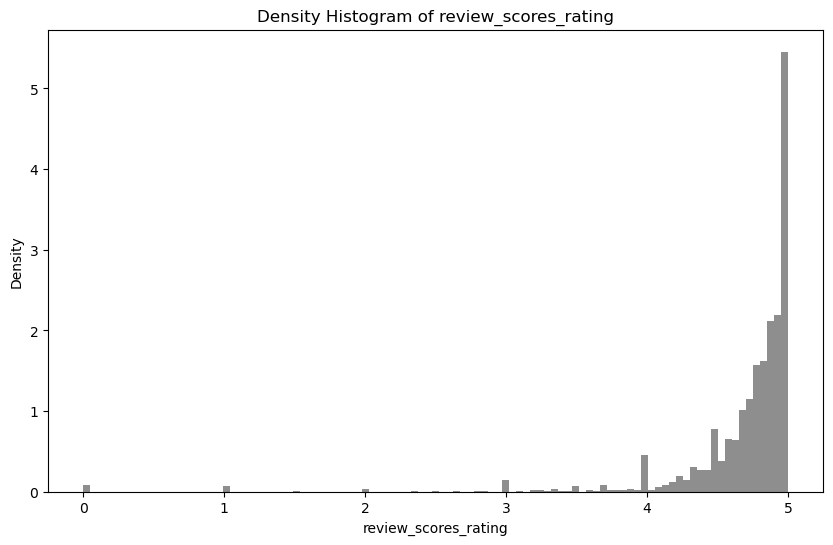

In [59]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(vwListings['review_scores_rating'], color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("review_scores_rating")
axes.set_ylabel("Density")
axes.set_title("Density Histogram of review_scores_rating")

plt.show()
plt.close()

A vast majority of scores are between 4 and 5, with most of those above 4.5. There are spikes at whole numbers, likely from listings with few reviews that average out there.

We also plot histograms for the other six scores to compare their distributions, seeing if any are notably different.

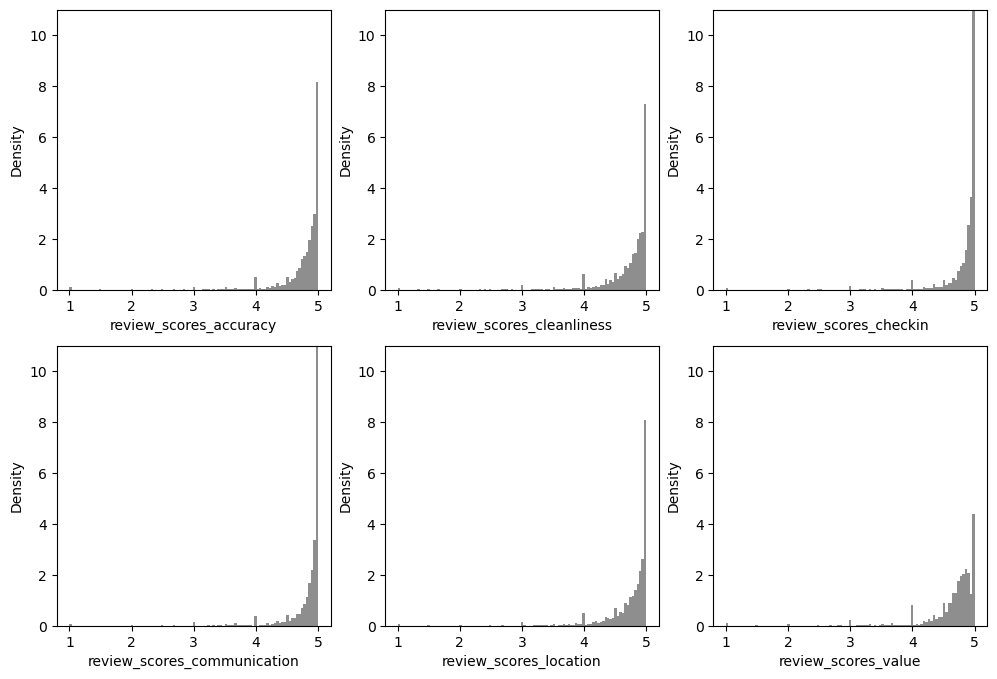

In [60]:
figure = plt.figure(figsize=(12,8))

axes = figure.add_subplot(2, 3, 1)
n, bins, patches = axes.hist(vwListings['review_scores_accuracy'], color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("review_scores_accuracy")
axes.set_ylabel("Density")
axes.set_ylim(0, 11)

axes = figure.add_subplot(2, 3, 2)
n, bins, patches = axes.hist(vwListings['review_scores_cleanliness'], color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("review_scores_cleanliness")
axes.set_ylabel("Density")
axes.set_ylim(0, 11)

axes = figure.add_subplot(2, 3, 3)
n, bins, patches = axes.hist(vwListings['review_scores_checkin'], color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("review_scores_checkin")
axes.set_ylabel("Density")
axes.set_ylim(0, 11)

axes = figure.add_subplot(2, 3, 4)
n, bins, patches = axes.hist(vwListings['review_scores_communication'], color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("review_scores_communication")
axes.set_ylabel("Density")
axes.set_ylim(0, 11)

axes = figure.add_subplot(2, 3, 5)
n, bins, patches = axes.hist(vwListings['review_scores_location'], color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("review_scores_location")
axes.set_ylabel("Density")
axes.set_ylim(0, 11)

axes = figure.add_subplot(2, 3, 6)
n, bins, patches = axes.hist(vwListings['review_scores_value'], color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("review_scores_value")
axes.set_ylabel("Density")
axes.set_ylim(0, 11)

plt.show()
plt.close()

review_scores_value has the most unique distribution. There are fewer perfect 5s and more 3s and 4s than the other review scores, and the values between 4 and 5 are less clustered near 5. review_scores_cleanliness exhibits those same characteristics to a lesser degree. review_scores_checkin and review_scores_communication are very closely clustered around 5.

### Reviews per month

A blank value in reviews_per_month indicates no reviews, so we replace blanks with 0.

In [61]:
vwListings['reviews_per_month'] = vwListings['reviews_per_month'].replace('', 0)

In [62]:
rpm = vwListings['reviews_per_month']

We print descriptive statistics.

In [63]:
pd.DataFrame(rpm.describe())

,reviews_per_month
count,7789.000000
mean,1.253524
std,1.856314
min,0.000000
25%,0.000000
50%,0.510000
75%,1.920000
max,59.650000


reviews_per_month ranges from 0 to 59.65, with a mean of 1.29 and a median of 0.51. It's unclear how a listing can get 59.65 reviews per month since that is more than 1 per day, so we look at the highest values.

In [64]:
pd.DataFrame(rpm.value_counts().sort_index(ascending=False)).head(10)

,reviews_per_month
59.65,1
31.67,1
21.34,1
21.32,1
16.27,1
14.80,1
14.03,1
13.06,1
12.96,1
12.86,1


There are two listings with more than one review per day, which shouldn't be possible. We look more closely at those listings:

In [65]:
vwListings.loc[rpm > 31, ['id','name','number_of_reviews_ltm','source_name','host_id']]

,id,name,number_of_reviews_ltm,source_name,host_id
4808,48425132,2 Queen Apt Suite | 2500 Penn Placemakr Experi...,561,listings_3_2023,389664429
7130,659366271388568374,Standard Queen Bed at Selina Union Market Wash...,517,listings_3_2023,459231442


The links to both of these listings appear dead. They should be dropped before modeling.

### Instant bookable

Instant bookable is boolean: t=true or f=false. It is whether the guest can automatically book the listing without the host requiring to accept their booking request. An indicator of a commercial listing.

In [66]:
vwListings.instant_bookable.describe()

count     7789
unique       2
top          f
freq      5174
Name: instant_bookable, dtype: object

In [67]:
vwListings.instant_bookable.value_counts()

f    5174
t    2615
Name: instant_bookable, dtype: int64

The number of "No" instant bookable is 2 times of The number of "Yes" instant bookable.

### Calculated host listings count

It is the number of listings that the host has in the current scrape, in the city/region geography.

In [68]:
vwListings.calculated_host_listings_count.describe()

count    7789.000000
mean       32.599820
std        62.292105
min         1.000000
25%         1.000000
50%         2.000000
75%        19.000000
max       235.000000
Name: calculated_host_listings_count, dtype: float64

The variable is definitely skewed. The mean is 32.4 listings and the median is 2 listings, much lower compared with mean. The 3rd quartile is 20x the 1st quartile. The minimum number of listings is "only" 1 listings and the maximum is 235 listings, so there are definitely extremes in the data. Let's count the frequency and plot a histogram of the data: 

In [69]:
vwListings.calculated_host_listings_count.value_counts()

1      3027
2       937
3       481
173     331
4       309
       ... 
30        3
91        2
79        2
22        1
155       1
Name: calculated_host_listings_count, Length: 62, dtype: int64

The majority of the number of listings that the host has is one listing. Let's plot histogram:

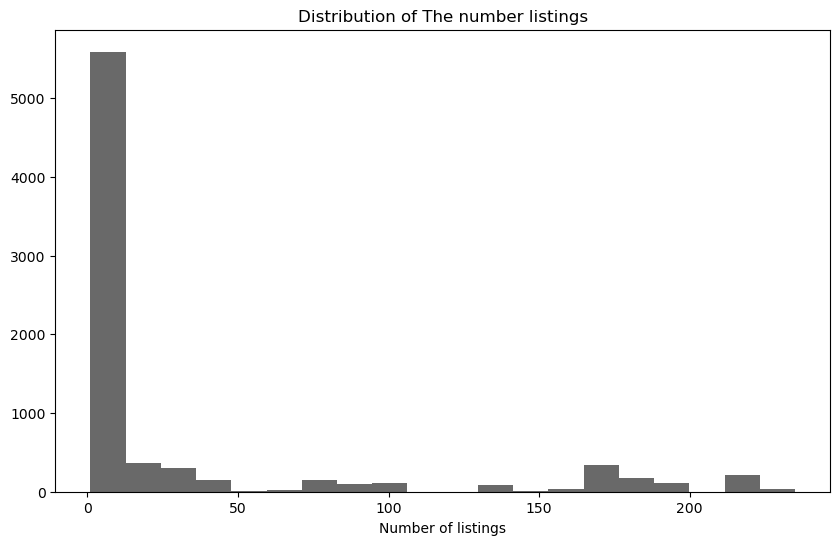

In [70]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.calculated_host_listings_count, color="dimgray", bins = 20)
axes.set_title("Distribution of The number listings")
axes.set_xlabel("Number of listings")

plt.show()
plt.close()

Interesting, there are some hosts that have more than 150 listings, but the most is still one listing.

### Latitude / Longitude

Use proximity to Washington, DC, attractions and main public transportation, determined by the GPS coordinates of an attraction as secondary data for model development. This will be our 2nd dataset.

In [71]:
#  the coordinates (latitude, longtitute of a place from google map )
smithsonian_lat = 38.8889532077163
smithsonian_long = -77.0259992316524
lincoln_memorial_lat = 38.8893771334115
lincoln_memorial_long = -77.0501761044084
capitol_lat = 38.8900557831996
capttol_long = -77.0090290467363
white_house_lat = 38.9103145107623
white_house_long = -77.0221504467353
library_of_congress_lat = 38.8888008852652
library_of_congress_long = -77.0047082755724
nationals_park_lat = 38.8731981381059
nationals_park_long = -77.0074329
national_zoo_lat = 38.9294590679026
national_zoo_long = -77.0492384835061
union_station_lat = 38.8973065709087
union_station_long = -77.00629767372
mcpherson_sq_lat = 38.9028682064423
mcpherson_sq_long = -77.0324745881233

In [72]:
# distance unit = miles
vwListings["distance_smitsonian"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(smithsonian_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(smithsonian_lat))
                                            *np.cos(np.radians(smithsonian_long-vwListings["longitude"])) )*3963*1.15077945

In [73]:
vwListings["distance_lincoln"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(lincoln_memorial_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(lincoln_memorial_lat))
                                            *np.cos(np.radians(lincoln_memorial_long-vwListings["longitude"])) )*3963*1.15077945

In [74]:
vwListings["distance_capitol"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(capitol_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(capitol_lat))
                                            *np.cos(np.radians(capttol_long-vwListings["longitude"])) )*3963*1.15077945

In [75]:
vwListings["distance_white_house"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(white_house_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(white_house_lat))
                                            *np.cos(np.radians(white_house_long-vwListings["longitude"])) )*3963*1.15077945

In [76]:
vwListings["distance_library_congress"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(library_of_congress_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(library_of_congress_lat))
                                            *np.cos(np.radians(library_of_congress_long-vwListings["longitude"])))*3963*1.15077945

In [77]:
vwListings["distance_nationals_park"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(nationals_park_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(nationals_park_lat))
                                            *np.cos(np.radians(nationals_park_long-vwListings["longitude"])) )*3963*1.15077945

In [78]:
vwListings["distance_national_zoo"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(national_zoo_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(national_zoo_lat))
                                            *np.cos(np.radians(national_zoo_long-vwListings["longitude"])) )*3963*1.15077945

In [79]:
vwListings["distance_railway"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(union_station_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(union_station_lat))
                                            *np.cos(np.radians(union_station_long-vwListings["longitude"])) )*3963*1.15077945

In [80]:
vwListings["distance_mcpherson"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(mcpherson_sq_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(mcpherson_sq_lat))
                                            *np.cos(np.radians(mcpherson_sq_long-vwListings["longitude"])) )*3963*1.15077945

### Distance to Smitsonian

The distance from hosts to Smitsonian is measured in terms of miles.

In [81]:
vwListings.distance_smitsonian.describe()

count    7789.000000
mean        3.236161
std         1.729053
min         0.491451
25%         2.006222
50%         2.670851
75%         4.061378
max         9.480365
Name: distance_smitsonian, dtype: float64

The variable is definitely skewed. The mean is 3.20 miles and the median is 2.64 miles, or about 17.5% lower. The 3rd quartile is nearly 2x the 1st quartile. The minimum distance is "only" 0.49 miles and the maximum is 9.48 miles, so there are definitely extremes in the data. Let's plot a histogram of the data:

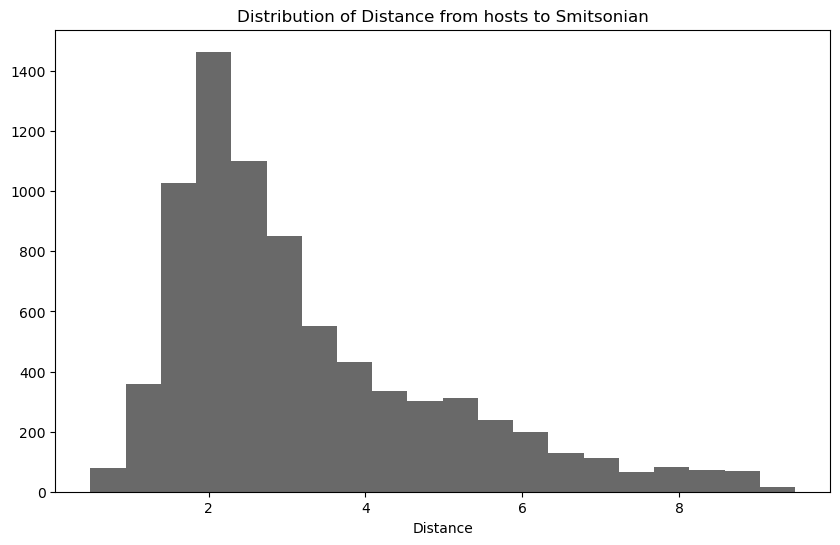

In [82]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.distance_smitsonian, color="dimgray", bins = 20)
axes.set_title("Distribution of Distance from hosts to Smitsonian")
axes.set_xlabel("Distance")

plt.show()
plt.close()

It is seen that the distribution does not appear to be normally distributed. The distance is quite variable among hosts and depends on their location.

### Distance to Lincoln

The distance from hosts to Lincoln Memorial is measured in terms of miles.

In [83]:
vwListings.distance_lincoln.describe()

count    7789.000000
mean        3.795329
std         1.783100
min         0.568090
25%         2.510566
50%         3.401899
75%         4.605329
max         9.831802
Name: distance_lincoln, dtype: float64

The distribution of distance is slightly skewed. The mean is 3.7 miles and the median is 3.4 miles, or about 9.7% lower. The 3rd quartile is nearly 1.9x the 1st quartile. The minimum distance is "only" 0.57 miles and the maximum is 9.83 miles, so there are definitely extremes in the data. Let's plot a histogram of the data:

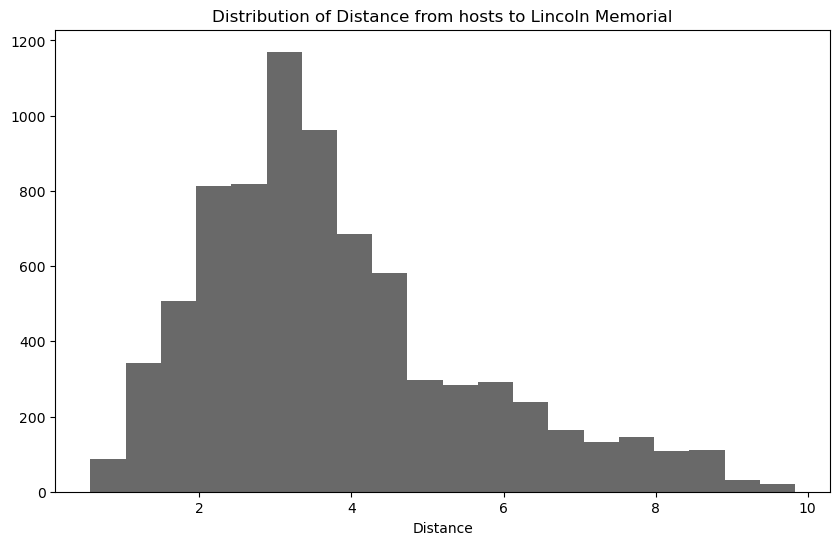

In [84]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.distance_lincoln, color="dimgray", bins = 20)
axes.set_title("Distribution of Distance from hosts to Lincoln Memorial")
axes.set_xlabel("Distance")

plt.show()
plt.close()

The data looks only slightly skewed right. The distance from hosts to the Lincoln Memorial range is quite wide and depends on the location.

### Distance to Capitol 

The distance from hosts to the capital is measured in terms of miles.

In [85]:
vwListings.distance_capitol.describe()

count    7789.000000
mean        3.081910
std         1.831488
min         0.309378
25%         1.686687
50%         2.707441
75%         4.102880
max         9.611845
Name: distance_capitol, dtype: float64

The variable is definitely skewed. The mean is 3.08 miles and the median is 2.74 miles, or around 11% lower. The 3rd quartile is nearly 2.4x the 1st quartile. The minimum distance is "only" 0.31 miles and the maximum is 9.6 miles, so there are definitely extremes in the data. Let's plot a histogram of the data:

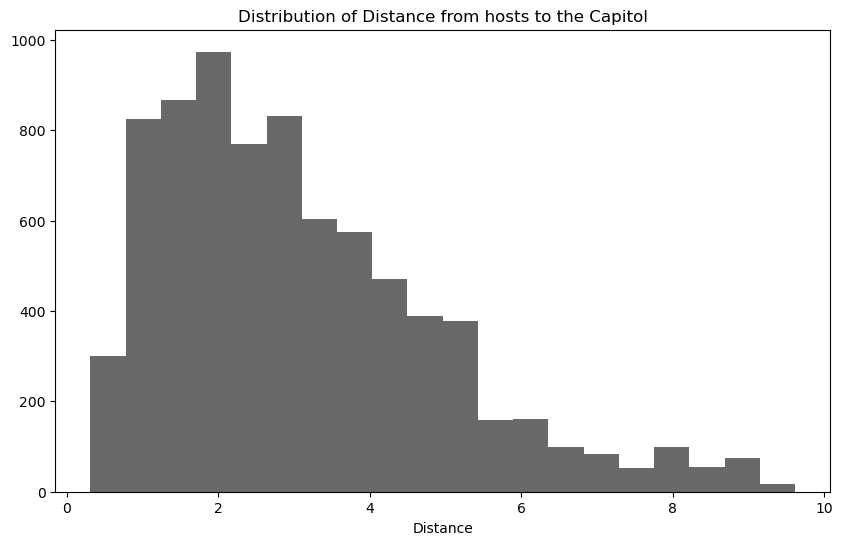

In [86]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.distance_capitol, color="dimgray", bins = 20)
axes.set_title("Distribution of Distance from hosts to the Capitol")
axes.set_xlabel("Distance")

plt.show()
plt.close()

It is seen that the distribution does not appear to be normally distributed. The distance from hosts to the Capitol range is quite wide and depends on the location. It is noticed that there is a lot of distance around 2–3.5 miles, which is quite close to the Capitol.

### Distance to White House

The distance from hosts to the White house is measured in terms of miles.

In [87]:
vwListings.distance_white_house.describe()

count    7789.000000
mean        2.614476
std         1.755253
min         0.004724
25%         1.279897
50%         2.248612
75%         3.507781
max         8.297130
Name: distance_white_house, dtype: float64

The variable is definitely skewed. The mean is 2.60 miles and the median is 2.24 miles, or around 13.9% lower. The 3rd quartile is nearly 2.7x the 1st quartile. The minimum distance is "only" 0.004 miles and the maximum is 8.29 miles, so there are definitely extremes in the data. Let's plot a histogram of the data:

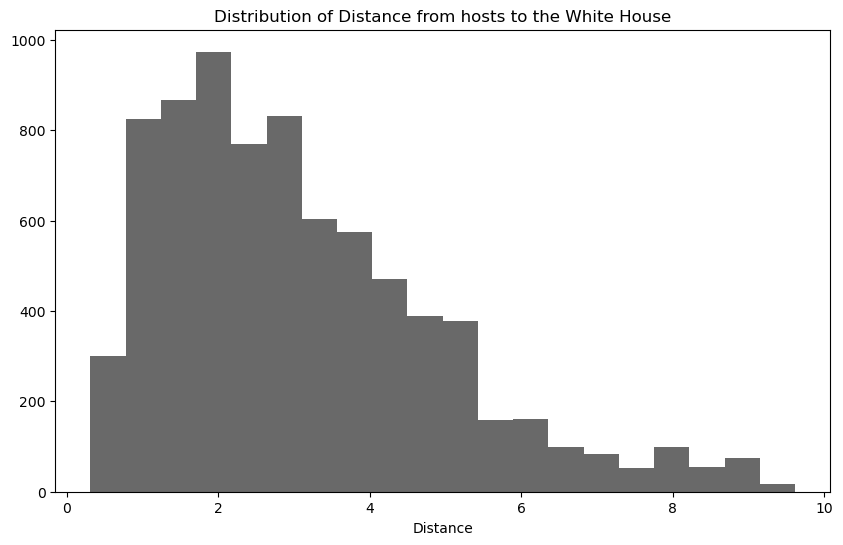

In [88]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.distance_capitol, color="dimgray", bins = 20)
axes.set_title("Distribution of Distance from hosts to the White House")
axes.set_xlabel("Distance")

plt.show()
plt.close()

The data looks only left-skewed distribution. The distance from hosts to the White House range is quite wide and depends on the location.

### Distance to Library Congress

The distance from hosts to the Library Congress is measured in terms of miles.

In [89]:
vwListings.distance_library_congress.describe()

count    7789.000000
mean        3.150483
std         1.886568
min         0.072757
25%         1.693830
50%         2.912848
75%         4.176021
max         9.780604
Name: distance_library_congress, dtype: float64

The minimum distance is 0.07 and the maximum is 9.78 miles, so there may be a few extremes in the data, but the main concentration of data indicates that the data may be slightly skewed. The mean is 3.15 miles, and the median is nearly that at 2.94 miles. The first quartile is 1.73 miles and the third quartile is 4.15 miles, both about equidistant from the median or mean.

Let's plot the data using a histogram:

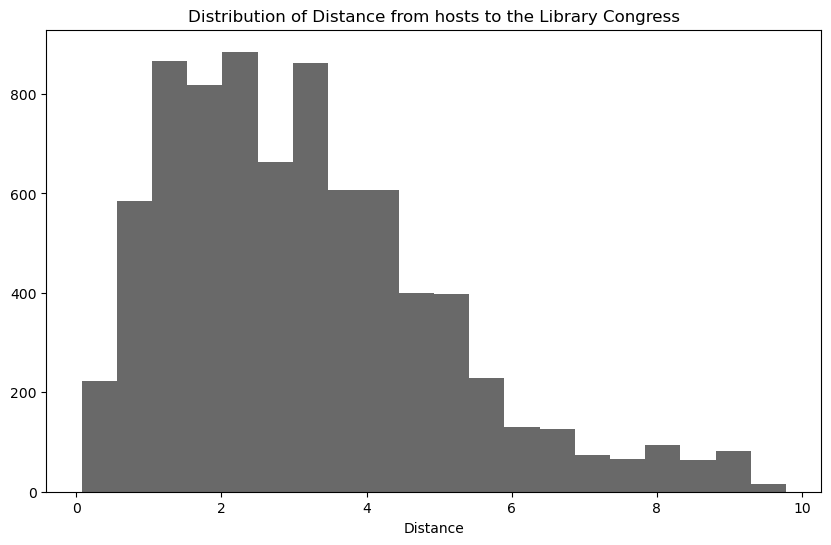

In [90]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.distance_library_congress, color="dimgray", bins = 20)
axes.set_title("Distribution of Distance from hosts to the Library Congress")
axes.set_xlabel("Distance")

plt.show()
plt.close()

The data looks only left-skewed distribution. The distance from hosts to the Library Congress range is quite wide and depends on the location.

### Distance to Nationals Park

The distance from hosts to the Nationals Park is measured in terms of miles.

In [91]:
vwListings.distance_nationals_park.describe()

count    7789.000000
mean        3.935953
std         1.970994
min         0.065556
25%         2.635940
50%         3.626002
75%         4.945059
max        10.936207
Name: distance_nationals_park, dtype: float64

The minimum distance is 0.07 and the maximum is 10.94 miles, so there may be a few extremes in the data, but the main concentration of data indicates that the data may be normally distribution. The mean is 3.93 miles, and the median is nearly that at 3.64 miles. The first quartile is 2.66 miles and the third quartile is 4.92 miles, both about equidistant from the median or mean.

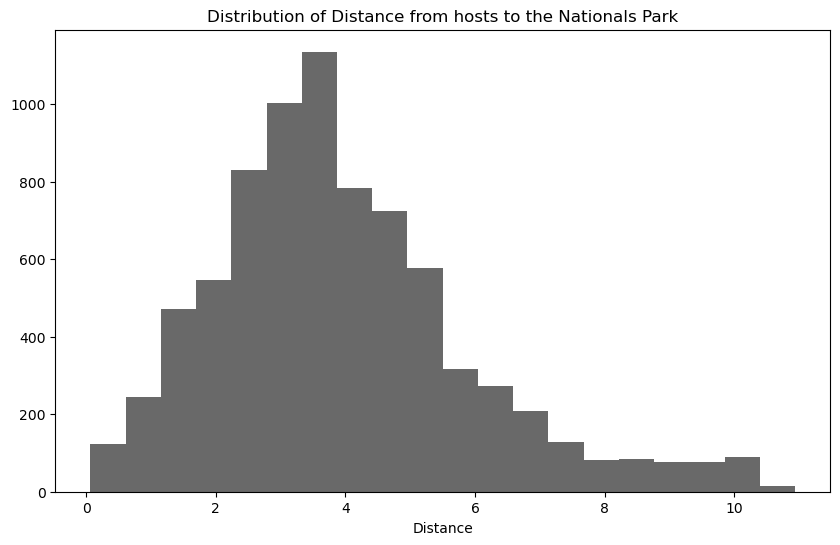

In [92]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.distance_nationals_park, color="dimgray", bins = 20)
axes.set_title("Distribution of Distance from hosts to the Nationals Park")
axes.set_xlabel("Distance")

plt.show()
plt.close()

The distribution looks very nearly normal but slightly skewed left.

### Distance to National Zoo

The distance from hosts to the Nationals Zoo is measured in terms of miles.

In [93]:
vwListings.distance_national_zoo.describe()

count    7789.000000
mean        3.506845
std         1.960097
min         0.122430
25%         1.933345
50%         3.182354
75%         4.656742
max        10.361138
Name: distance_national_zoo, dtype: float64

The variable is definitely skewed. The mean is 3.46 miles and the median is 3.13 miles, or around 9.5% lower. The 3rd quartile is nearly 2.4x the 1st quartile. The minimum distance is "only" 0.12 miles and the maximum is 10.36 miles, so there are definitely extremes in the data. Let's plot a histogram of the data:

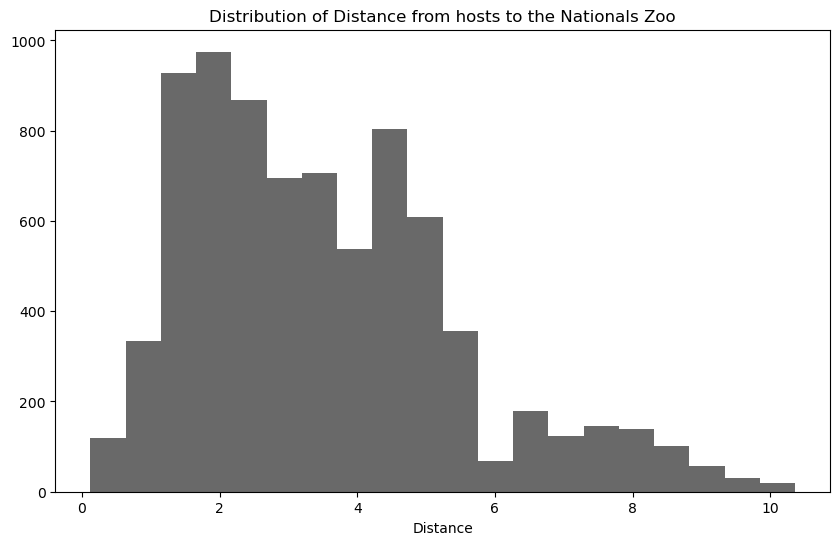

In [94]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.distance_national_zoo, color="dimgray", bins = 20)
axes.set_title("Distribution of Distance from hosts to the Nationals Zoo")
axes.set_xlabel("Distance")

plt.show()
plt.close()

It is seen that the distribution does not appear to be normally distributed. A distance range is quite wide and depends on the location.

### Distance to Railway

The distance from hosts to the Main DC railway station (Union Station) is measured in terms of miles.

In [95]:
vwListings.distance_railway.describe()

count    7789.000000
mean        2.844496
std         1.804984
min         0.137688
25%         1.460478
50%         2.569116
75%         3.888085
max         9.103872
Name: distance_railway, dtype: float64

The variable is slightly skewed. The mean is 2.84 miles and the median is 2.57 miles, or around 9% lower. The 3rd quartile is nearly 2.6x the 1st quartile. The minimum distance is "only" 0.14 miles and the maximum is 9.10 miles, so there are definitely extremes in the data. Let's plot a histogram of the data:

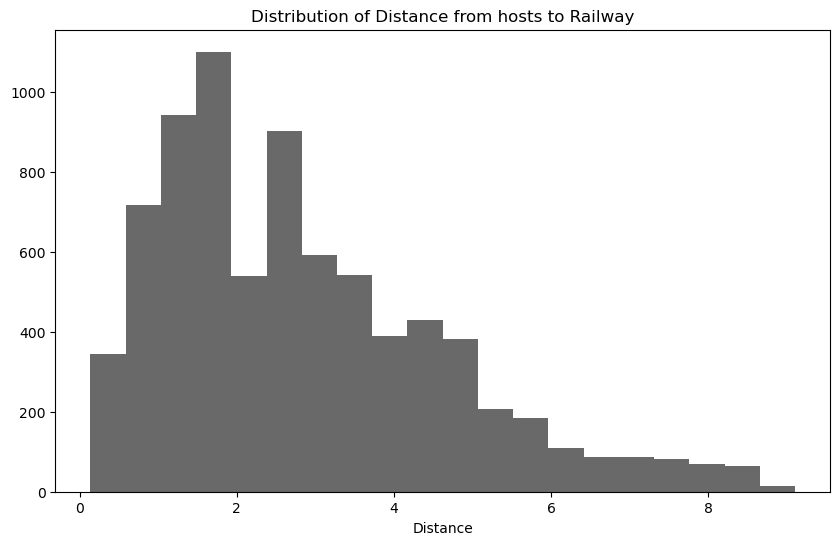

In [96]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.distance_railway, color="dimgray", bins = 20)
axes.set_title("Distribution of Distance from hosts to Railway")
axes.set_xlabel("Distance")

plt.show()
plt.close()

The data looks only left-skewed distribution. The distance from hosts to the Main DC railway station (Union Station) range is quite wide and depends on the location.

### Distance to McPherson

The distance from hosts to Mcpherson Sq Metro Station (station is the nearest one to Downtown Washington DC) is measured in terms of miles.

In [97]:
vwListings.distance_mcpherson.describe()

count    7789.000000
mean        2.866247
std         1.774102
min         0.089814
25%         1.542069
50%         2.455509
75%         3.668104
max         8.810736
Name: distance_mcpherson, dtype: float64

The variable is slightly skewed. The mean is 2.83 miles and the median is 2.41 miles, or around 13% lower. The 3rd quartile is nearly 2.4x the 1st quartile. The minimum distance is "only" 0.09 miles and the maximum is 8.8 miles, so there are definitely extremes in the data. Let's plot a histogram of the data:

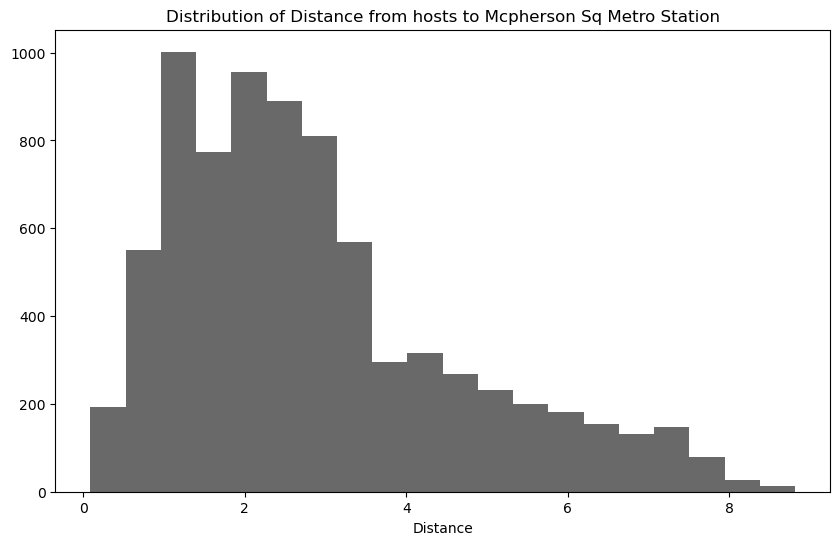

In [98]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(vwListings.distance_mcpherson, color="dimgray", bins = 20)
axes.set_title("Distribution of Distance from hosts to Mcpherson Sq Metro Station")
axes.set_xlabel("Distance")

plt.show()
plt.close()

It is seen that the distribution does not appear to be normally distributed. The distance from hosts to the Mcpherson Sq Metro Station range is quite wide and depends on the location. It is noticed that there is a lot of distance around 1–3 miles, which is quite close to the Capitol.

## Listings - pairwise EDA

Next, we will perform pairwise EDA between price and important variables.

In [99]:
def describe_by_category(data, numeric, categorical, transpose=False):
    grouped = data.groupby(categorical)
    grouped_y = grouped[numeric].describe()
    if transpose:
        print(grouped_y.transpose())
    else:
        print(grouped_y)

### Price vs. Host response rate

In [100]:
price_response_rate = vwListings[['price', 'host_response_rate']]
price_response_rate.drop(price_response_rate.loc[price_response_rate['price']==0].index, inplace=True)
price_response_rate.drop(price_response_rate.loc[price_response_rate['host_response_rate']=='N/A'].index, inplace=True)
price_response_rate.dropna(inplace=True)
price_response_rate.host_response_rate = pd.to_numeric(price_response_rate.host_response_rate)

In [101]:
print("r   = ", stats.pearsonr(price_response_rate.price, price_response_rate.host_response_rate)[0])
print("rho = ", stats.spearmanr(price_response_rate.price, price_response_rate.host_response_rate)[0])

r   =  0.0005741360829867558
rho =  -0.026284027150733524


Pearson's correlation coefficient, $r$, is only 0.0134 which indicates a weak positive relationship. Spearman's is at -0.0557 which might indicate that the weak negative monotonic relationship. Let's plot the data:

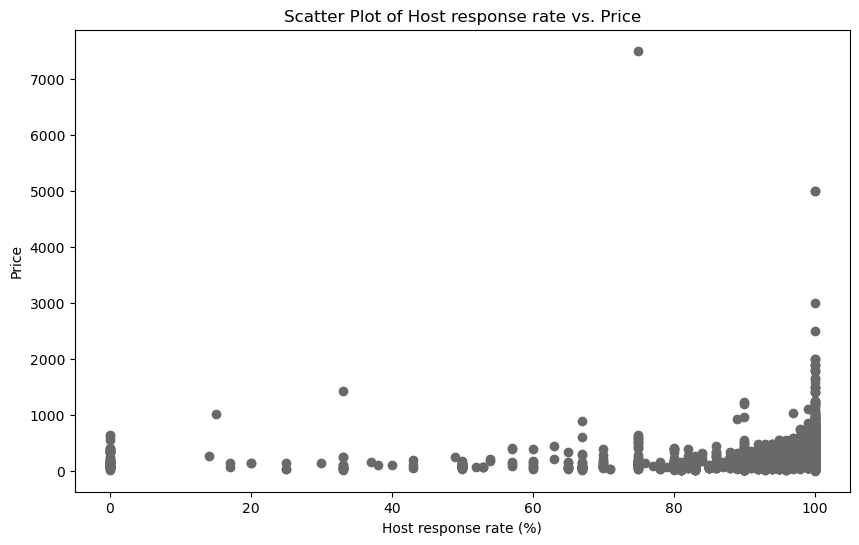

In [102]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(price_response_rate.host_response_rate, price_response_rate.price, marker="o", color="DimGray")

axes.set_ylabel("Price")
axes.set_xlabel("Host response rate (%)")
axes.set_title("Scatter Plot of Host response rate vs. Price")

plt.show()
plt.close()

The majority of the data points are located in the bottom right corner. it means that it is common to see the host response rate is between 90% to 100%. However, it does not look like there is an existing relationship between Host response rate and Price because no matter the host response rate is, the majority of the unit price is less than 1000 dollars per night. And also, we can see one outlier in this chart. That outlier has 100% in host response rate but the price up to 5000 dollars per night.

### Price vs. Host acceptance rate

In [103]:
price_acceptance_rate = vwListings[['price', 'host_acceptance_rate']]
price_acceptance_rate.drop(price_acceptance_rate.loc[price_acceptance_rate['price']==0].index, inplace=True)
price_acceptance_rate.drop(price_acceptance_rate.loc[price_acceptance_rate['host_acceptance_rate']=='N/A'].index, inplace=True)
price_acceptance_rate.dropna(inplace=True)
price_acceptance_rate.host_acceptance_rate = pd.to_numeric(price_acceptance_rate.host_acceptance_rate)

In [104]:
print("r   = ", stats.pearsonr(price_acceptance_rate.price, price_acceptance_rate.host_acceptance_rate)[0])
print("rho = ", stats.spearmanr(price_acceptance_rate.price, price_acceptance_rate.host_acceptance_rate)[0])

r   =  0.10431100226232161
rho =  0.12099126861139442


Pearson's correlation coefficient, $r$, is only 0.0087 which indicates a very weak positive relationship. Spearman's is at 0.118 which might indicate that a very weak positive monotonic relationship. Let's plot the data:

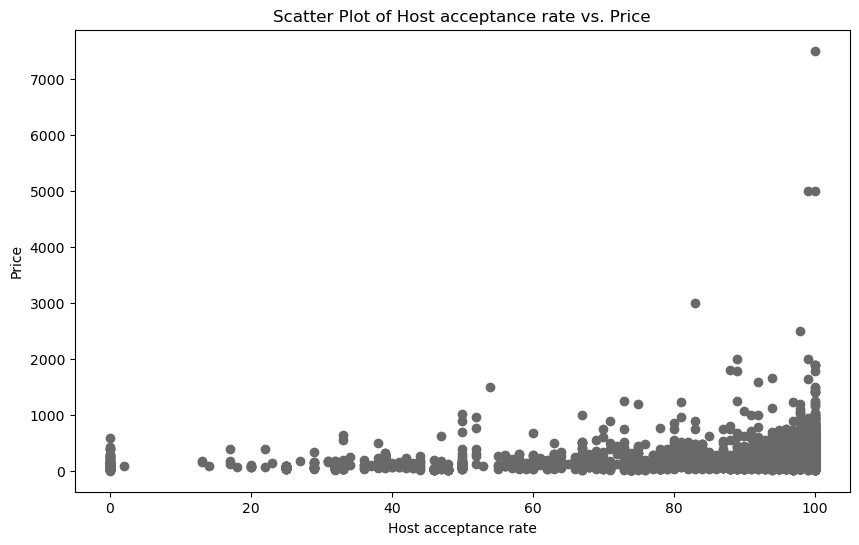

In [105]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(price_acceptance_rate.host_acceptance_rate, price_acceptance_rate.price, marker="o", color="DimGray")

axes.set_ylabel("Price")
axes.set_xlabel("Host acceptance rate")
axes.set_title("Scatter Plot of Host acceptance rate vs. Price")

plt.show()
plt.close()

Similar to Host response rate vs. Price, it is kinda obvious that there is no relationship between Host acceptance rate vs. Price. All the data points are at the bottom right corner. There is one outlier as well. Basically, all the unit price seems common to be under 1000 dollars per night no matter the host acceptance rate is.

### Price vs. Host is superhost

In [106]:
price_superhost = vwListings[['price', 'host_is_superhost']].copy()

In [107]:
price_superhost['host_is_superhost'] = price_superhost['host_is_superhost'].replace({'': 'f'})

In [108]:
describe_by_category(price_superhost, "price", "host_is_superhost", transpose=True)

host_is_superhost            f            t
count              5581.000000  2208.000000
mean                184.514424   194.415308
std                 250.054690   185.581851
min                  10.000000    22.000000
25%                  83.000000    96.000000
50%                 132.000000   143.000000
75%                 216.000000   218.000000
max                7500.000000  2500.000000


Based on the statistics above, the mean price of not-a-superhost is lower than a superhost by 10 dollars per night. However, the maximum price which is 7,500 dollars is listed under not-a-superhost. The standard deviation of non-superhost is 

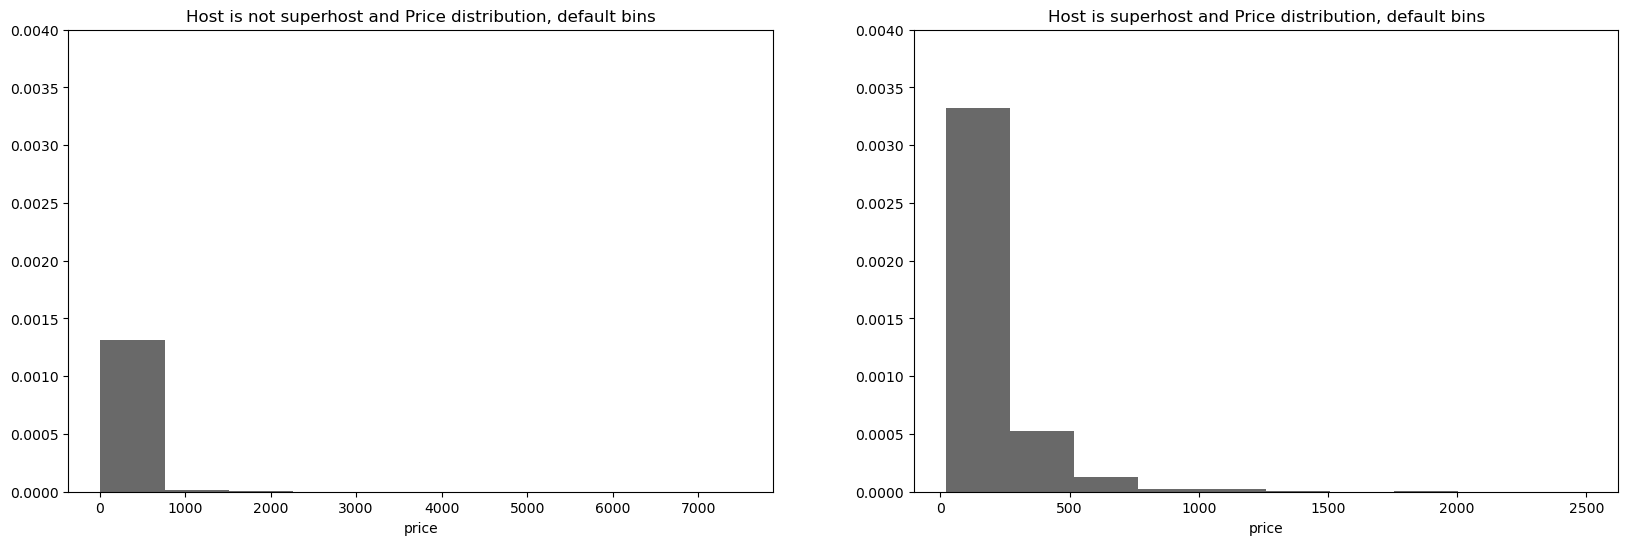

In [109]:
grouped = price_superhost.groupby("host_is_superhost")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist(grouped["price"].get_group("f"), color="DimGray", density=True)
axes.set_title("Host is not superhost and Price distribution, default bins")
axes.set_xlabel("price")
axes.set_ylim((0,0.0040))

axes = figure.add_subplot(1, 2, 2)
axes.hist(grouped["price"].get_group("t"), color="DimGray", density=True)
axes.set_title("Host is superhost and Price distribution, default bins")
axes.set_xlabel("price")
axes.set_ylim((0,0.0040))

plt.show()
plt.close()

Based on the two distributions above, if the host is a superhost, it looks like they can charge more money per night. From 250 dollars per night as, the density/frequency on the superhost chart is higher.

### Price vs. Host identity verified

In [110]:
price_identity = vwListings[['price', 'host_identity_verified']].copy()

In [111]:
price_identity['host_identity_verified'] = price_identity['host_identity_verified'].replace({'': 'f'})

In [112]:
describe_by_category(price_identity, "price", "host_identity_verified", transpose=True)

host_identity_verified            f            t
count                    987.000000  6802.000000
mean                     204.035461   184.895766
std                      360.072665   208.943965
min                       10.000000    16.000000
25%                       85.000000    88.000000
50%                      125.000000   137.000000
75%                      200.000000   219.000000
max                     7500.000000  5995.000000


Althought the number of hosts with identity is verified is higher than the number of hosts without identity is verified, the mean price of the hosts without identity verified is higher. However, the price in terms of minimum price, the 1st quartile, the 2nd quartile and the 3rd quartile price of the hosts with identity verified is higher. Let's plot to see:

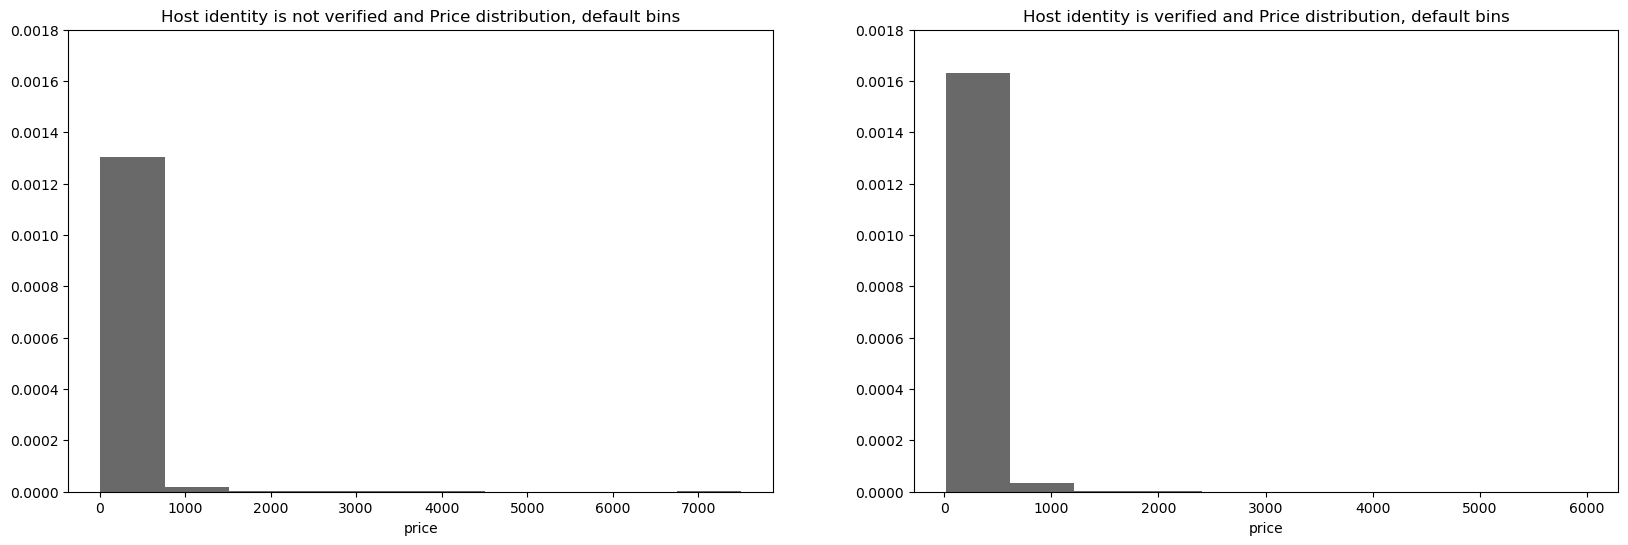

In [113]:
grouped = price_identity.groupby("host_identity_verified")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist(grouped["price"].get_group("f"), color="DimGray", density=True)
axes.set_title("Host identity is not verified and Price distribution, default bins")
axes.set_xlabel("price")
axes.set_ylim((0,0.0018))

axes = figure.add_subplot(1, 2, 2)
axes.hist(grouped["price"].get_group("t"), color="DimGray", density=True)
axes.set_title("Host identity is verified and Price distribution, default bins")
axes.set_xlabel("price")
axes.set_ylim((0,0.0018))

plt.show()
plt.close()

The two charts are pretty similar. The only difference is that the number of hosts with identity verified is higher. Nothing is much special here.

In [114]:
def correlation(data, x, y):
    print("Correlation coefficients:")
    r = stats.pearsonr(data[x], data[y])[0]
    print( "r   =", r, f"({classify_correlation(r)})")
    rho = stats.spearmanr(data[x], data[y])[0]
    print( "rho =", rho, f"({classify_correlation(rho)})")

In [115]:
def classify_correlation(r):
    r = abs(r)
    if r < 0.16:
        return "very weak"
    if r < 0.29:
        return "weak"
    if r < 0.49:
        return "low"
    if r < 0.69:
        return "moderate"
    if r < 0.89:
        return "strong"
    return "very strong"

### Property type vs. Room type

Earlier we noticed more listings with property_type = 'Room in hotel' than room_type = 'Hotel room'. We look more closely at listings whose property_type begins with 'room':

In [116]:
pd.DataFrame(vwListings.loc[vwListings['property_type'].str.split().str.get(0) == 'Room', ['room_type', 'property_type']].value_counts())

0
room_type       property_type                
Private room    Room in hotel              97
                Room in boutique hotel     59
Entire home/apt Room in aparthotel         16
Hotel room      Room in hostel              9
                Room in bed and breakfast   6
                Room in boutique hotel      1

There are 117 Rooms in boutiqe hotels and 98 Rooms in hotels with room_type = 'Private room' instead of 'Hotel room'.

In [117]:
pd.DataFrame(vwListings.loc[vwListings['room_type'] == 'Hotel room', 'property_type'].value_counts())

,property_type
Room in hostel,9
Room in bed and breakfast,6
Room in boutique hotel,1


In addition to 'Room in boutique hotel' and 'Room in hotel', 'Private room in bed and breakfast' is another property_type that isn't listed as a hotel room but should be. More evidence for this can be found by comparing property_type with price.

###  Price vs. Property type

We look at descriptive statistics for the top 20 property types by count.

In [118]:
vwListings.groupby('property_type')['price'].describe().sort_values('count', ascending=False).head(20).sort_index()

,count,mean,std,min,25%,50%,75%,max
property_type,,,,,,,,
Entire condo,570.0,160.285965,105.090875,39.0,99.00,132.0,188.75,1425.0
Entire guest suite,459.0,117.535948,50.257593,41.0,87.00,106.0,135.00,399.0
Entire guesthouse,68.0,213.058824,211.345150,66.0,111.75,135.5,202.50,1237.0
Entire home,908.0,335.874449,497.899913,10.0,146.00,225.0,350.00,7500.0
Entire loft,25.0,176.480000,87.892036,64.0,100.00,175.0,225.00,442.0
Entire rental unit,2475.0,170.713131,129.776311,34.0,105.00,144.0,197.50,3000.0
Entire serviced apartment,567.0,241.913580,92.599185,65.0,181.00,228.0,289.00,716.0
Entire townhouse,614.0,284.833876,267.343225,45.0,150.00,223.0,331.75,4357.0
Entire vacation home,17.0,162.411765,67.808608,101.0,120.00,125.0,208.00,322.0


Unsurprisingly, shared rooms have the lowest mean price. "Entire" listings also generally have higher mean price than private rooms, which are generally low. Somewhat surprisingly, rooms in hotels (including private rooms in bed and breakfasts) have some of the highest prices. This gives us more evidence that 'Room in hotel', 'Room in boutique hotel', and 'Private room in bed and breakfast' should be grouped together with hotel rooms instead of with private rooms. 

We create a new feature room_type_mod that implements this change.

In [119]:
vwListings['room_type_mod'] = vwListings['room_type']
vwListings.loc[vwListings['property_type'].isin(['Room in hotel', 'Room in boutique hotel', 'Private room in bed and breakfast']),
        'room_type_mod'] = 'Hotel room'

### Price vs. Room type 

We look at descriptive statistics for room_type and room_type_mod.

In [120]:
vwListings.groupby('room_type')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,5752.0,212.073887,249.060236,10.0,110.0,159.0,243.0,7500.0
Hotel room,16.0,41.562500,40.834575,25.0,25.0,29.0,29.0,175.0
Private room,1902.0,122.055205,168.751593,20.0,51.0,72.0,106.0,2000.0
Shared room,119.0,53.621849,25.157804,16.0,35.0,45.0,61.5,140.0


In [121]:
vwListings.groupby('room_type_mod')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
room_type_mod,,,,,,,,
Entire home/apt,5752.0,212.073887,249.060236,10.0,110.0,159.0,243.0,7500.0
Hotel room,216.0,379.768519,307.126203,25.0,202.0,335.0,460.5,1903.0
Private room,1702.0,88.592244,102.099389,20.0,50.0,68.0,95.0,2000.0
Shared room,119.0,53.621849,25.157804,16.0,35.0,45.0,61.5,140.0


The changes of the previous section greatly increase the Hotel room mean price, making it the highest at 335. They also greatly decrease the Private room mean price, making it the second-lowest at 89. Entire home/apt has the second-highest mean of 202 and Shared room has the lowest mean of 54. 

For each room_type, the median is lower than the mean and closer to the 25th percentile than the 75th percentile. This indicates right-tailed distributions, which we verify by displaying price histograms for each room_type_mod.

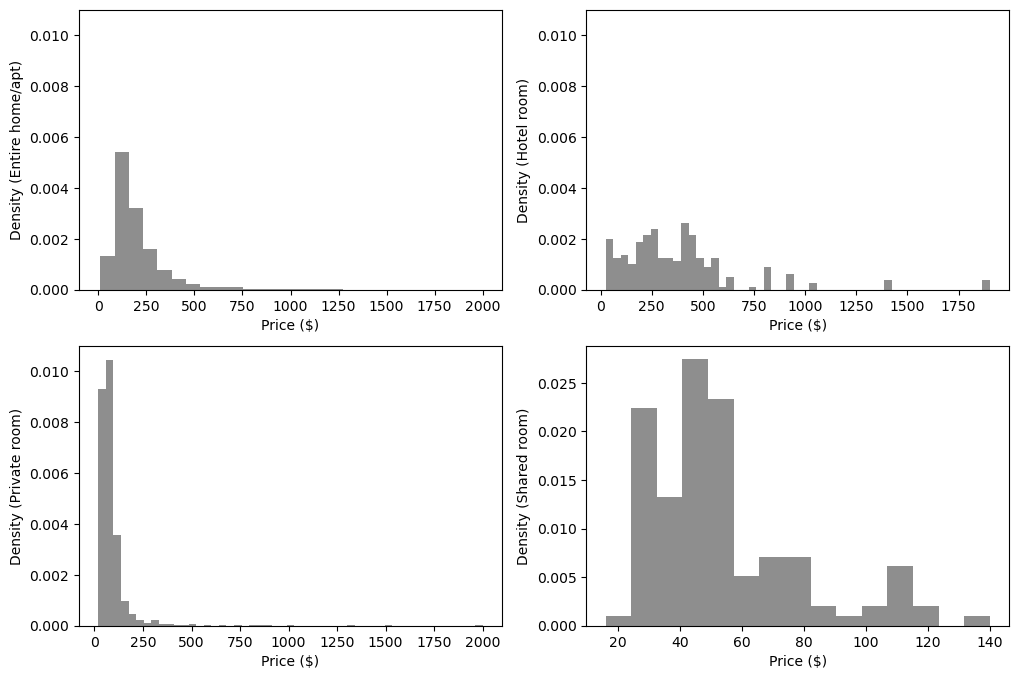

In [122]:
figure = plt.figure(figsize=(12,8))

axes = figure.add_subplot(2, 2, 1)
n, bins, patches = axes.hist(vwListings.loc[vwListings['room_type_mod']=='Entire home/apt', 'price'], 
                             color="DimGray", density=True, bins=101, alpha=0.75)
axes.set_xlabel("Price ($)")
axes.set_ylabel("Density (Entire home/apt)")
axes.set_ylim(0, 0.011)
axes.set_xlim(-100, 2100)

axes = figure.add_subplot(2, 2, 2)
n, bins, patches = axes.hist(vwListings.loc[vwListings['room_type_mod']=='Hotel room','price'], 
                             color="DimGray", density=True, bins=51, alpha=0.75)
axes.set_xlabel("Price ($)")
axes.set_ylabel("Density (Hotel room)")
axes.set_ylim(0, 0.011)

axes = figure.add_subplot(2, 2, 3)
n, bins, patches = axes.hist(vwListings.loc[vwListings['room_type_mod']=='Private room', 'price'],
                             color="DimGray", density=True, bins=51, alpha=0.75)
axes.set_xlabel("Price ($)")
axes.set_ylabel("Density (Private room)")
axes.set_ylim(0, 0.011)

axes = figure.add_subplot(2, 2, 4)
n, bins, patches = axes.hist(vwListings.loc[vwListings['room_type_mod']=='Shared room','price'], 
                             color="DimGray", density=True, bins=15, alpha=0.75)
axes.set_xlabel("Price ($)")
axes.set_ylabel("Density (Shared room)")

plt.show()
plt.close()

Each room type has a right-skewed distribution, though the skew is more pronounced for 'Entire home/apt' and 'Private room'.

### Price vs. Accommodates

Accommodates describes the maximum capacity of the Airbnb listing. Overall, it should affect price as it would mean more guests would be staying at the listing. More resources are required to host the guests therefore increasing cost for the owner and needing to increase the price. We expect there to be a moderate to strong correlation between accommodates and price.

In [123]:
tempDF = vwListings
tempDF["accommodates"].replace('', np.nan, inplace=True)
tempDF.dropna(subset=['accommodates'], inplace=True)

In [124]:
correlation(tempDF, "price", "accommodates")

Correlation coefficients:
r   = 0.43292645844489025 (low)
rho = 0.6003608558104045 (moderate)


Pearson's correlation coefficient 𝑟, outputs as 0.46 which indicates a low positive relationship. For Spearman's coefficient, it is slightly higher at 0.59 which indicates a moderate positive relationship. We can plot the data to get a visualization of this pairwise relationship.

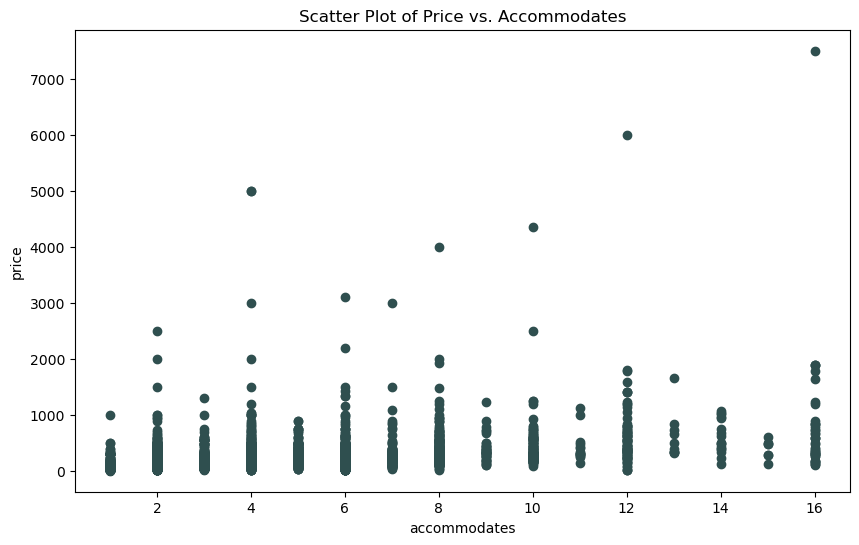

In [125]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( tempDF["accommodates"], tempDF["price"], marker="o", color="darkslategray")

axes.set_ylabel("price")
axes.set_xlabel("accommodates")
axes.set_title("Scatter Plot of Price vs. Accommodates")

plt.show()
plt.close()

When looking at the scatter plot visualization, there is a slight pattern as accommodates increases, then price increases. This would be reflective on the correlation coefficients that show a moderate positive relationship between accommodates and price. The scatter plot is indicative of that.

### Price vs. Bedrooms

Overall, number of bedrooms should affect price as well as it would make a listing more desirable and could accommodate more guests for their stay. We expect there to be a moderate positive relationship between number of bathrooms and price.

In [126]:
tempDF = vwListings
tempDF["bedrooms"].replace('', np.nan, inplace=True)
tempDF.dropna(subset=['bedrooms'], inplace=True)

In [127]:
correlation(tempDF, "price", "bedrooms")

Correlation coefficients:
r   = 0.38096771580575817 (low)
rho = 0.4785766729555743 (low)


Pearson's correlation coefficient 𝑟, outputs as 0.46 which indicates a low positive relationship. For Spearman's coefficient, it is slightly higher at 0.52 which also indicates a moderate positive relationship. This is contrary to our belief that there is a moderate positive relationship between the two variables. We can plot the data to get a visualization of this pairwise relationship.

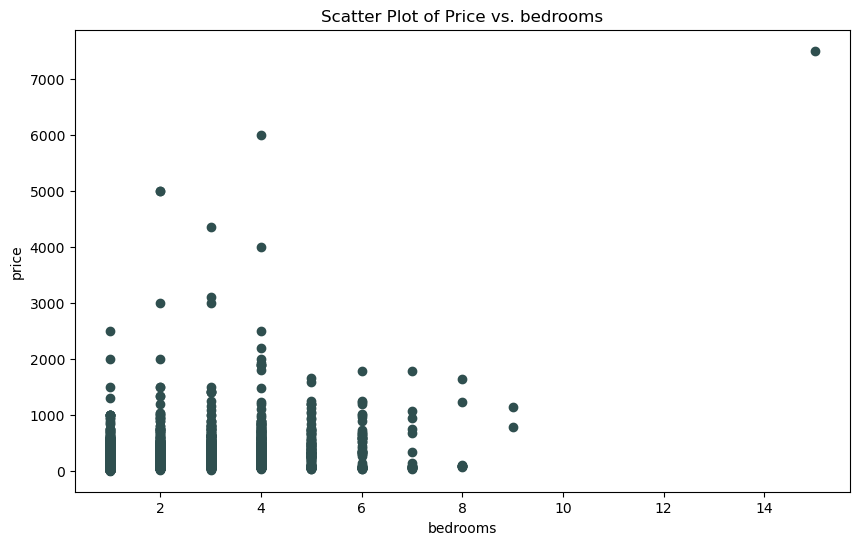

In [128]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( tempDF["bedrooms"], tempDF["price"], marker="o", color="darkslategray")

axes.set_ylabel("price")
axes.set_xlabel("bedrooms")
axes.set_title("Scatter Plot of Price vs. bedrooms")

plt.show()
plt.close()

When looking at the scatter plot visualization, there is not really a pattern as number of bathrooms increases. This would be reflective on the correlation coefficients that show a low positive relationship between number of bedrooms and and price.

Overall, number of beds should affect price as well as it would make a listing more desirable and could accommodate more guests for their stay. We expect there to be a moderate positive relationship between number of bathrooms and price.

### Price vs. Beds

In [129]:
tempDF = vwListings
tempDF["beds"].replace('', np.nan, inplace=True)
tempDF.dropna(subset=['beds'], inplace=True)

In [130]:
correlation(tempDF, "price", "beds")

Correlation coefficients:
r   = 0.40461933965051466 (low)
rho = 0.5103750868451481 (moderate)


Pearson's correlation coefficient 𝑟, outputs as 0.45 which indicates a low positive relationship. For Spearman's coefficient, it is slightly higher at 0.52 which also indicates a moderate positive relationship. We can plot the data to get a visualization of this pairwise relationship.

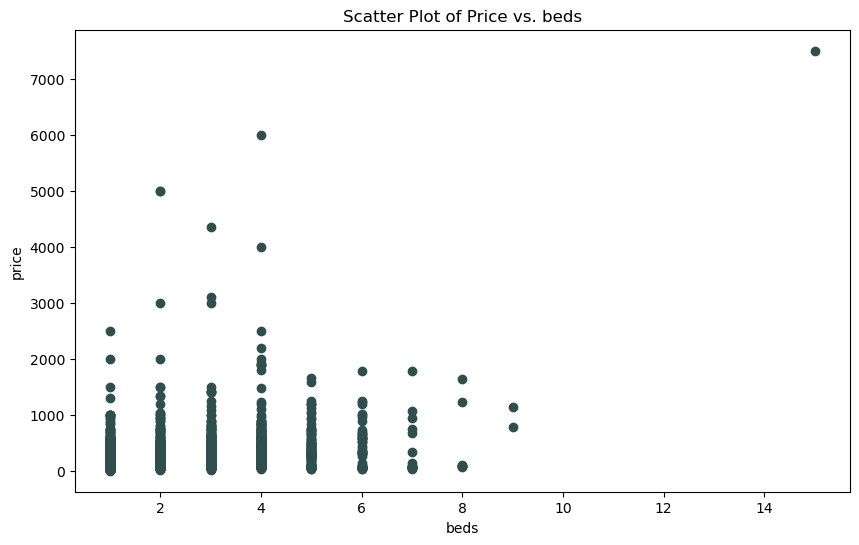

In [131]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( tempDF["bedrooms"], tempDF["price"], marker="o", color="darkslategray")

axes.set_ylabel("price")
axes.set_xlabel("beds")
axes.set_title("Scatter Plot of Price vs. beds")

plt.show()
plt.close()

When looking at the scatter plot visualization, there is not really a pattern as number of bathrooms increases. This would be reflective on the correlation coefficients that show a low positive to moderate relationship between number of beds and and price.

### Price vs. Minimum nights

We display a scatterplot of price vs. minimum nights, expecting the highest prices to be for short-term rentals.

In [132]:
min_nt = vwListings['minimum_nights']
max_nt = copy.copy(vwListings['maximum_nights'])

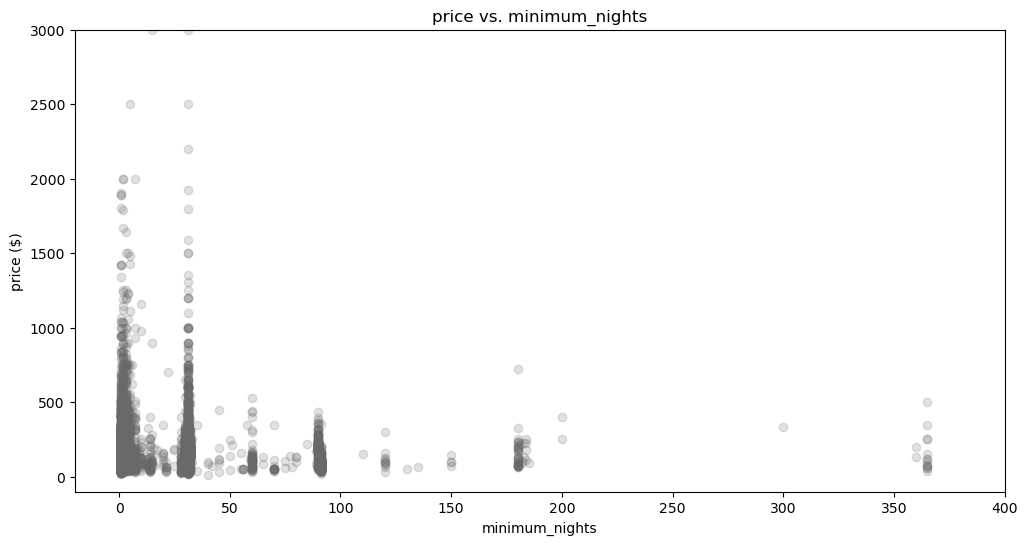

In [133]:
figure = plt.figure(figsize=(12, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(min_nt, vwListings['price'], marker="o", color="dimgray", alpha=0.2)

axes.set_ylabel("price ($)")
axes.set_xlabel("minimum_nights")
axes.set_title("price vs. minimum_nights")

axes.set_xlim(-20, 400)
axes.set_ylim(-100, 3000)

plt.show()
plt.close()

As expected, the highest prices are generally in short-term rentals. There seems to be a negative relationship here. We calculate correlation coefficients to verify this.

In [134]:
print("r   = ", stats.pearsonr(vwListings['minimum_nights'], vwListings['price'])[0])
print("rho = ", stats.spearmanr(vwListings['minimum_nights'], vwListings['price'])[0])

r   =  -0.05770951953686751
rho =  -0.12340997011754969


Pearson's coefficient is only slightly negative at -0.077, indicating a weak negative relationship. Spearman's coefficient is lower at -0.159, indicating some non-linearity in the relationship.

### Price vs. Number of reviews

We do not exepect the relation between price and number of review. Let's look first at correlation coefficients:

In [135]:
print("r   = ", stats.pearsonr(vwListings.price.astype(float), vwListings.number_of_reviews)[0])
print("rho = ", stats.spearmanr(vwListings.price.astype(float), vwListings.number_of_reviews)[0])

r   =  -0.053263345631751335
rho =  -0.05692331304514072


Pearson's correlation coefficient,  𝑟 , is only -0.05 which indicates a very weak negative relationship. Spearman's is at -0.04 which might indicate weak monotonic relationship. Let's plot the data:

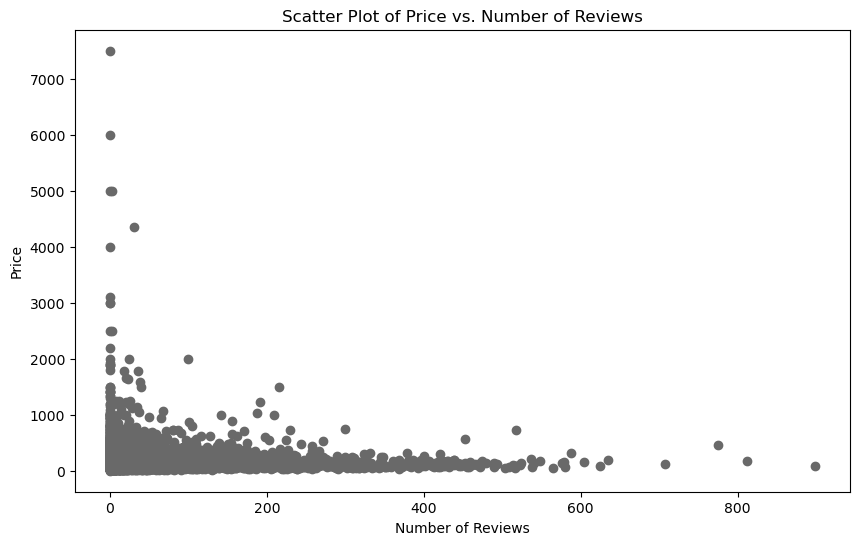

In [136]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( vwListings.number_of_reviews, vwListings.price, marker="o", color="dimgray")

axes.set_ylabel("Price")
axes.set_xlabel("Number of Reviews")
axes.set_title("Scatter Plot of Price vs. Number of Reviews")

plt.show()
plt.close()

There appears to be no relationship between price and number of reviews as the data spreads in an unclear pattern.

### Price vs. Instant bookable

We do not exepect that there are no diferent between price of instant bookable and price of no instant bookable.Let's look first at correlation coefficients:

In [137]:
describe_by_category(vwListings, "price", "instant_bookable", transpose=True)

instant_bookable            f            t
count             5174.000000  2615.000000
mean               183.044840   195.782027
std                258.205761   174.833299
min                 10.000000    16.000000
25%                 86.000000    89.000000
50%                131.000000   150.000000
75%                200.000000   250.000000
max               7500.000000  1903.000000


Let's plot histogram:

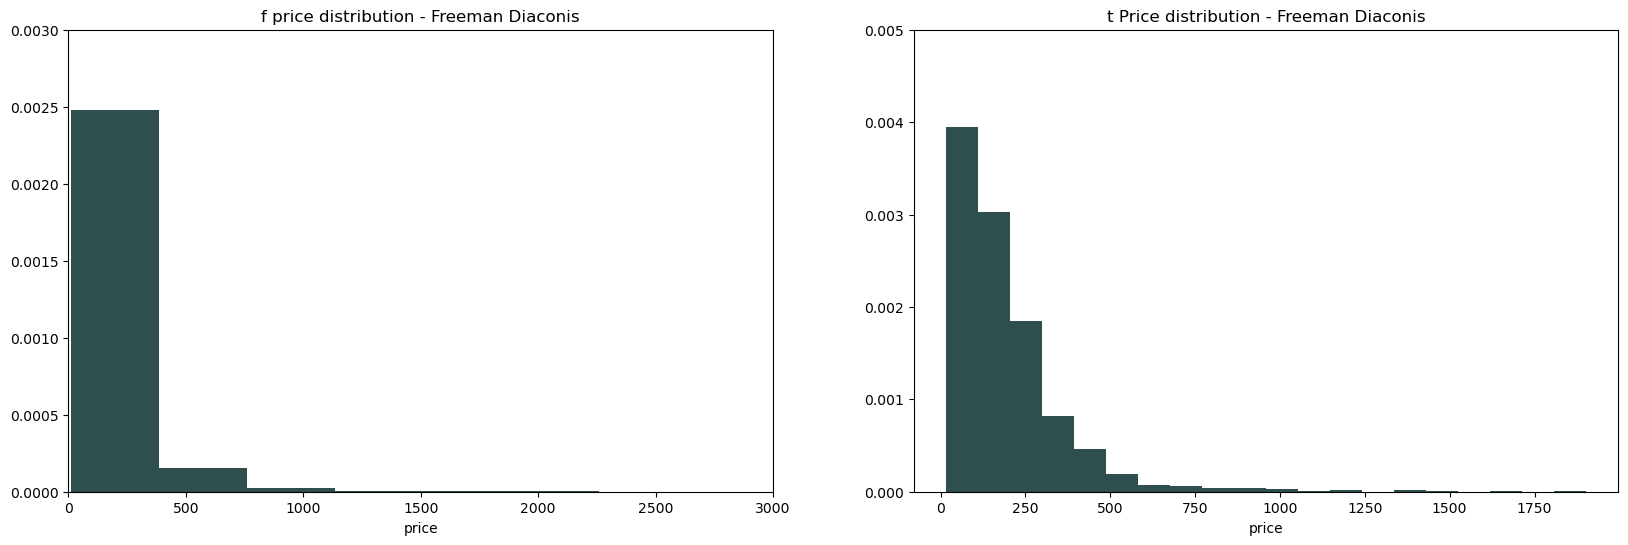

In [138]:
grouped = vwListings.groupby("instant_bookable")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist(grouped["price"].get_group("f"),bins=20,color="darkslategray",density=True)
axes.set_title("f price distribution - Freeman Diaconis")
axes.set_xlabel("price")
axes.set_ylim((0,0.0030))
axes.set_xlim((0,3000))

axes = figure.add_subplot(1, 2, 2)
axes.hist(grouped["price"].get_group("t"),bins=20,color="darkslategray",density=True)
axes.set_title("t Price distribution - Freeman Diaconis")
axes.set_xlabel("price")
axes.set_ylim((0,0.005))

plt.show()
plt.close()

The price of "no" instant_bookable is concentrated between 0 and 500 dollars. While The price of "Yes" instant_bookable is concentrated between 0 and 250 dollars.

### Price vs. Distance to Smitsonian

We expect that distance to attraction is inversely proportional to price. The longer the distance, the lower the price.

Let's look first at correlation coefficients, for which we expect an inverse relation between price and distance.

In [139]:
print("r   = ", stats.pearsonr(vwListings.price.astype(float), vwListings.distance_smitsonian)[0])
print("rho = ", stats.spearmanr(vwListings.price.astype(float), vwListings.distance_smitsonian)[0])

r   =  -0.13818449895736445
rho =  -0.329200597222753


Pearson's correlation coefficient, 𝑟 , is at -0.15, which indicates a weak negative relationship. Spearman's is also interesting at -0.37, which might indicate a weak monotonic relationship. Let's plot the data:

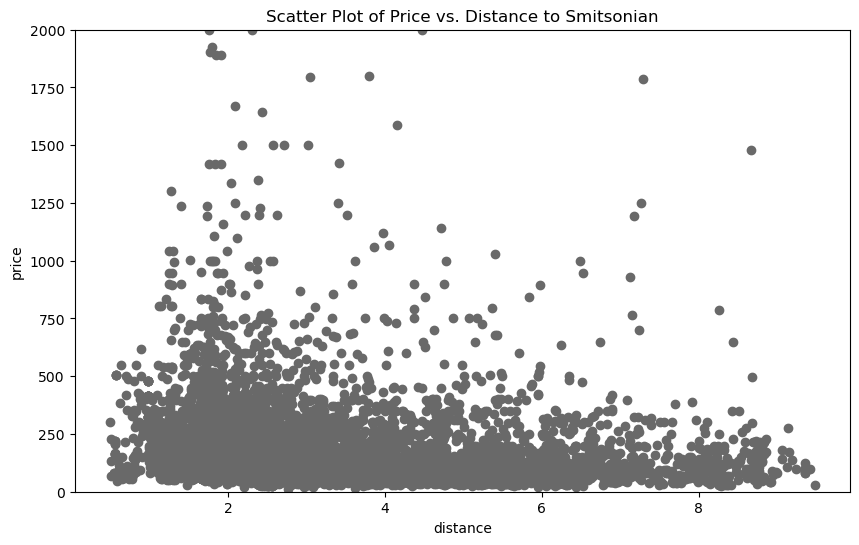

In [140]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( vwListings.distance_smitsonian, vwListings.price, marker="o", color="dimgray")

plt.ylim(0,2000)
axes.set_ylabel("price")
axes.set_xlabel("distance")
axes.set_title("Scatter Plot of Price vs. Distance to Smitsonian")

plt.show()
plt.close()

There appears to be no relationship between price and distance as the data spreads in an unclear pattern.

### Price vs. Distance to Lincoln

We expect that distance to attraction is inversely proportional to price. The longer the distance, the lower the price.

Let's look first at correlation coefficients, for which we expect an inverse relation between price and distance.

In [141]:
print("r   = ", stats.pearsonr(vwListings.price.astype(float), vwListings.distance_lincoln)[0])
print("rho = ", stats.spearmanr(vwListings.price.astype(float), vwListings.distance_lincoln)[0])

r   =  -0.15968269780742345
rho =  -0.3327368108825401


Pearson's correlation coefficient, 𝑟 , is at -0.17, which indicates a weak negative relationship. Spearman's is also interesting at -0.35, which might indicate a weak monotonic relationship. Let's plot the data:

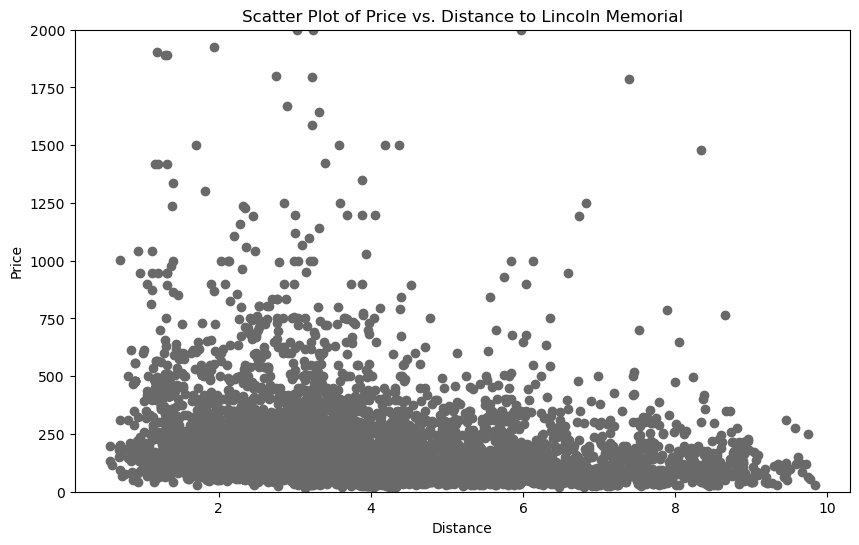

In [142]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(vwListings.distance_lincoln, vwListings.price, marker="o", color="dimgray")

axes.set_ylabel("Price")
axes.set_xlabel("Distance")
axes.set_title("Scatter Plot of Price vs. Distance to Lincoln Memorial")
plt.ylim(0,2000)
plt.show()
plt.close()

There appears to be no relationship between price and distance as the data spreads in an unclear pattern.

### Price vs. Distance to White House

We expect that distance to attraction is inversely proportional to price. The longer the distance, the lower the price.

Let's look first at correlation coefficients, for which we expect an inverse relation between price and distance.

In [143]:
print("r   = ", stats.pearsonr(vwListings.price.astype(float), vwListings.distance_white_house)[0])
print("rho = ", stats.spearmanr(vwListings.price.astype(float), vwListings.distance_white_house)[0])

r   =  -0.10156686743874839
rho =  -0.2184384765206693


Pearson's correlation coefficient, 𝑟 , is at -0.11, which indicates a weak negative relationship. Spearman's is also interesting at -0.24, which might indicate a weak monotonic relationship. Let's plot the data:

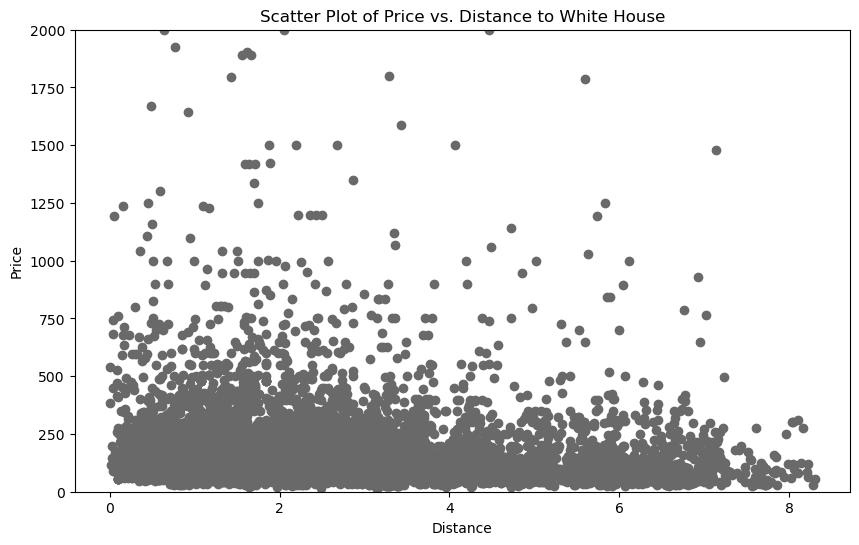

In [144]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(vwListings.distance_white_house, vwListings.price, marker="o", color="dimgray")

axes.set_ylabel("Price")
axes.set_xlabel("Distance")
axes.set_title("Scatter Plot of Price vs. Distance to White House")
plt.ylim(0,2000)
plt.show()
plt.close()

There appears to be no relationship between price and distance as the data spreads in an unclear pattern.

### Price vs. Distance to Library Congress

We expect that distance to attraction is inversely proportional to price. The longer the distance, the lower the price.

Let's look first at correlation coefficients, for which we expect an inverse relation between price and distance.

In [145]:
print("r   = ", stats.pearsonr(vwListings.price.astype(float), vwListings.distance_library_congress)[0])
print("rho = ", stats.spearmanr(vwListings.price.astype(float), vwListings.distance_library_congress)[0])

r   =  -0.08999028776320264
rho =  -0.2148270303188059


Pearson's correlation coefficient, 𝑟 , is at -0.10, which indicates a weak negative relationship. Spearman's is also interesting at -0.24, which might indicate a weak monotonic relationship. Let's plot the data:

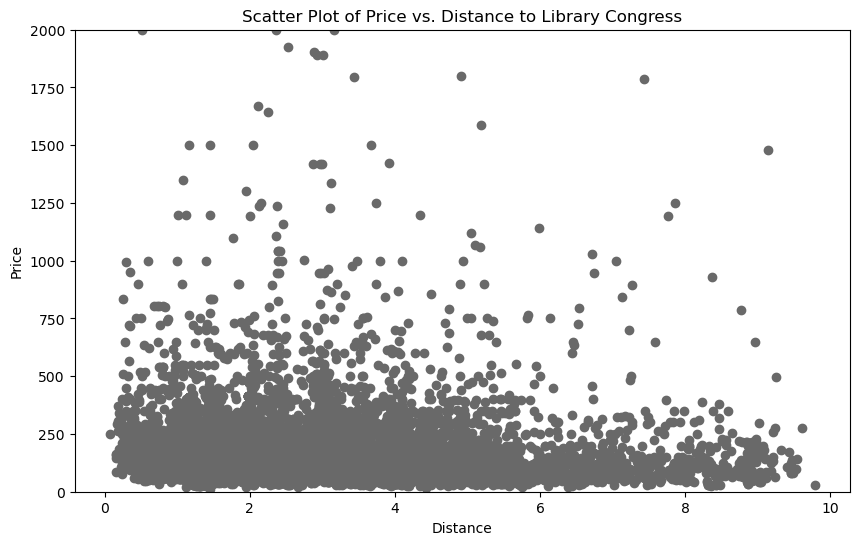

In [146]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(vwListings.distance_library_congress, vwListings.price, marker="o", color="dimgray")

axes.set_ylabel("Price")
axes.set_xlabel("Distance")
axes.set_title("Scatter Plot of Price vs. Distance to Library Congress")
plt.ylim(0,2000)
plt.show()
plt.close()

There appears to be no relationship between price and distance as the data spreads in an unclear pattern.

### Price vs. Distance to Nationals Park

We expect that distance to attraction is inversely proportional to price. The longer the distance, the lower the price.

Let's look first at correlation coefficients, for which we expect an inverse relation between price and distance.

In [147]:
print("r   = ", stats.pearsonr(vwListings.price.astype(float), vwListings.distance_nationals_park)[0])
print("rho = ", stats.spearmanr(vwListings.price.astype(float), vwListings.distance_nationals_park)[0])

r   =  -0.08937310706630244
rho =  -0.19522214836575033


Pearson's correlation coefficient, 𝑟 , is at -0.10, which indicates a weak negative relationship. Spearman's is also interesting at -0.22, which might indicate a weak monotonic relationship. Let's plot the data:

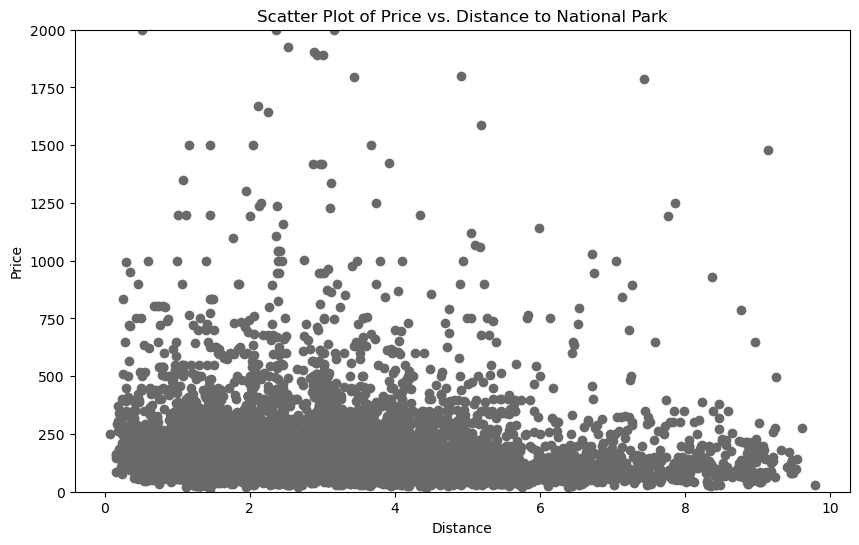

In [148]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(vwListings.distance_library_congress, vwListings.price, marker="o", color="dimgray")

axes.set_ylabel("Price")
axes.set_xlabel("Distance")
axes.set_title("Scatter Plot of Price vs. Distance to National Park")
plt.ylim(0,2000)
plt.show()
plt.close()

There appears to be no relationship between price and distance as the data spreads in an unclear pattern.

### Price vs. Distance to Railway

We expect that distance to railway station is inversely proportional to price. The longer the distance, the lower the price.

Let's look first at correlation coefficients, for which we expect an inverse relation between price and distance.

In [149]:
print("r   = ", stats.pearsonr(vwListings.price.astype(float), vwListings.distance_railway)[0])
print("rho = ", stats.spearmanr(vwListings.price.astype(float), vwListings.distance_railway)[0])

r   =  -0.09066886912136202
rho =  -0.22580251559795878


Pearson's correlation coefficient, 𝑟 , is at -0.10, which indicates a weak negative relationship. Spearman's is also interesting at -0.25, which might indicate a weak monotonic relationship. Let's plot the data:

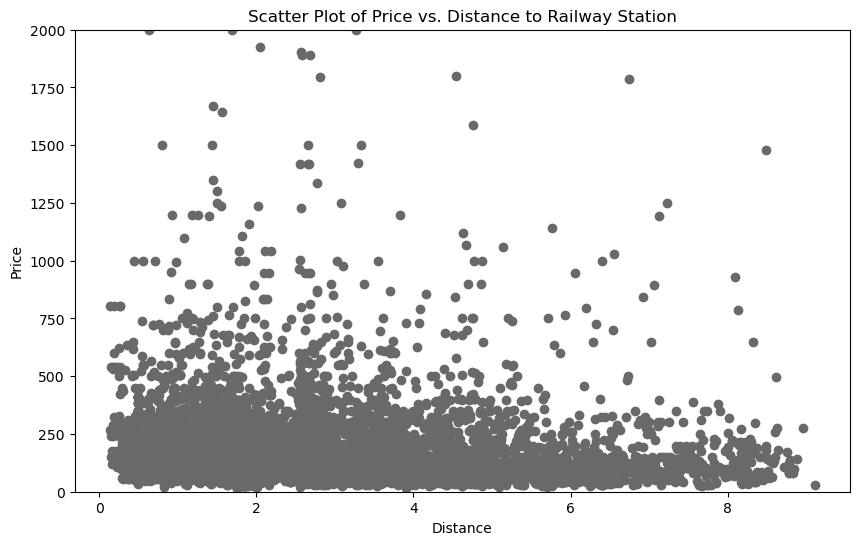

In [150]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(vwListings.distance_railway, vwListings.price, marker="o", color="dimgray")

axes.set_ylabel("Price")
axes.set_xlabel("Distance")
axes.set_title("Scatter Plot of Price vs. Distance to Railway Station")
plt.ylim(0,2000)
plt.show()
plt.close()

There appears to be no relationship between price and distance as the data spreads in an unclear pattern.

### Price vs. Distance to McPherson

We expect that distance to Mcpherson Square station is inversely proportional to price. The longer the distance, the lower the price.

Let's look first at correlation coefficients, for which we expect an inverse relation between price and distance.

In [151]:
print("r   = ", stats.pearsonr(vwListings.price.astype(float), vwListings.distance_mcpherson)[0])
print("rho = ", stats.spearmanr(vwListings.price.astype(float), vwListings.distance_mcpherson)[0])

r   =  -0.13664323488191799
rho =  -0.2901443430141569


Pearson's correlation coefficient, 𝑟 , is at -0.15, which indicates a weak negative relationship. Spearman's is also interesting at -0.31, which might indicate a weak monotonic relationship. Let's plot the data:

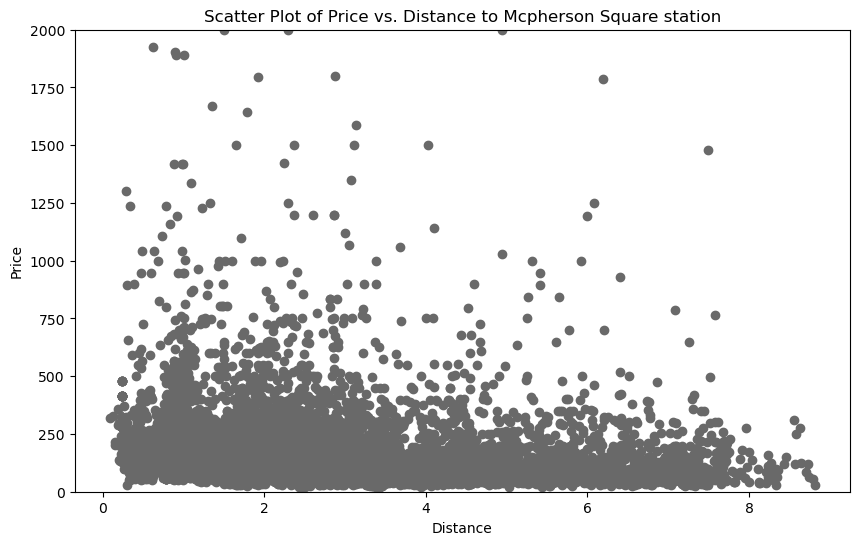

In [152]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(vwListings.distance_mcpherson, vwListings.price, marker="o", color="dimgray")

axes.set_ylabel("Price")
axes.set_xlabel("Distance")
axes.set_title("Scatter Plot of Price vs. Distance to Mcpherson Square station")
plt.ylim(0,2000)
plt.show()
plt.close()

There appears to be no relationship between price and distance as the data spreads in an unclear pattern.

## Baseline Model

We would like to give our hosts recommendations on how to price their listing(s) on a given day. We want to recommend a price that is consistent with the prices of other listings. To make a recommendation, we predict the price based on past listing prices. 

We're indifferent between overestimates and underestimates. Both lead to decreased revenue for hosts, just in different ways: overestimates lead to fewer bookings, while underestimates leave money that could have been charged on the table. We'd also like to penalize large errors more than small errors. Therefore, we will use the mean as a null model since it minimizes mean squared error.

We calculate the mean price in our sample:

In [153]:
price = vwListings['price']
price_predict = round(price.mean(), 2)
price_predict

187.32

The Baseline Model predicts a price / day of 178.81.

To see if we can get an idea of the error bounds on this prediction, we calculate the price standard deviation.

In [154]:
round(vwListings['price'].std(), 2)

233.62

The standard deviation is 205.54. Price isn't close to normally distributed, so we can't use the standard deviation to put 95% probability bounds on this prediction. The standard deviation is also greater than the mean, so negative numbers are less than one standard deviation away from the prediction. Consequently, we can't even apply Chebyshev's inequality to the prediction.

In [155]:
mse = ((price - price_predict)**2).sum()/len(price)
print('sigma:', round(np.sqrt(mse), 2))

sigma: 233.61


Our loss function is mean squared error. Applying the Baseline Model to the data results in $\sigma = 205.53$.

## Distributional Model

In [157]:
from scipy.stats import norm, lognorm

### Log-Gaussian Distribution

We expect the relevant factors for determining price to generally have <i>multiplicative</i> rather than additive effects. For instance, consider which sort of effect is more plausible for the bedrooms in a listing:

<ol>
    <li>Each extra bedroom increases the price by 25%.</li>
    <li>Each extra bedroom increases the price by $50.</li>
</ol>

Option 1 makes more sense. An extra bedroom in a nice neighborhood is going to be worth more in absolute terms than an extra bedroom in a bad neighborhood.

Gaussian distributions are generally good models of the results of many small <i>additive</i> effects, but Log-Gaussian distributions are better models of the results of many small multiplicative effects. The two are related: if $Y$ has a Gaussian distribution, then $X = exp(Y)$ has a Log-Gaussian distribution.

We parameterize the distribution with the sigma parameter set to the standard deviation of $log(price)$ and the scale parameter set to $exp(\bar{log(price)})$.

In [158]:
mu = np.log(price).mean()
sigma = np.log(price).std()

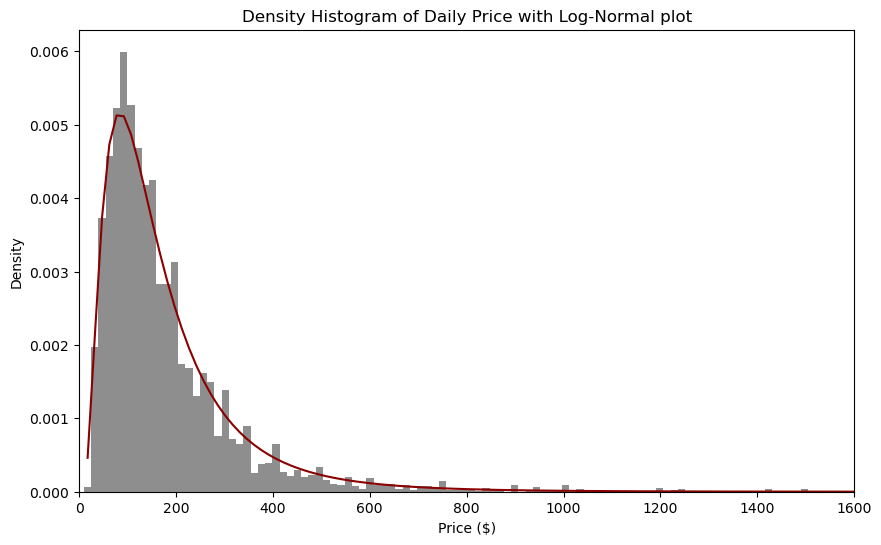

In [159]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(price, color="DimGray", density=True, bins=501, alpha=0.75) # 501
axes.set_xlabel("Price ($)")
axes.set_ylabel("Density")
axes.set_title("Density Histogram of Daily Price with Log-Normal plot")

axes.set_xlim(0,1600)

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]    

ys = [lognorm.pdf(k, s=sigma, scale=np.exp(mu)) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()

This seems like a pretty good model for the data, though there are some clear weaknesses. It overestimates the probability of very small pricees and underestimates the probability of prices around 100 and extremely high prices.

We compare the cumulative distributions to get a better idea of the strengths and weaknesses of the model.

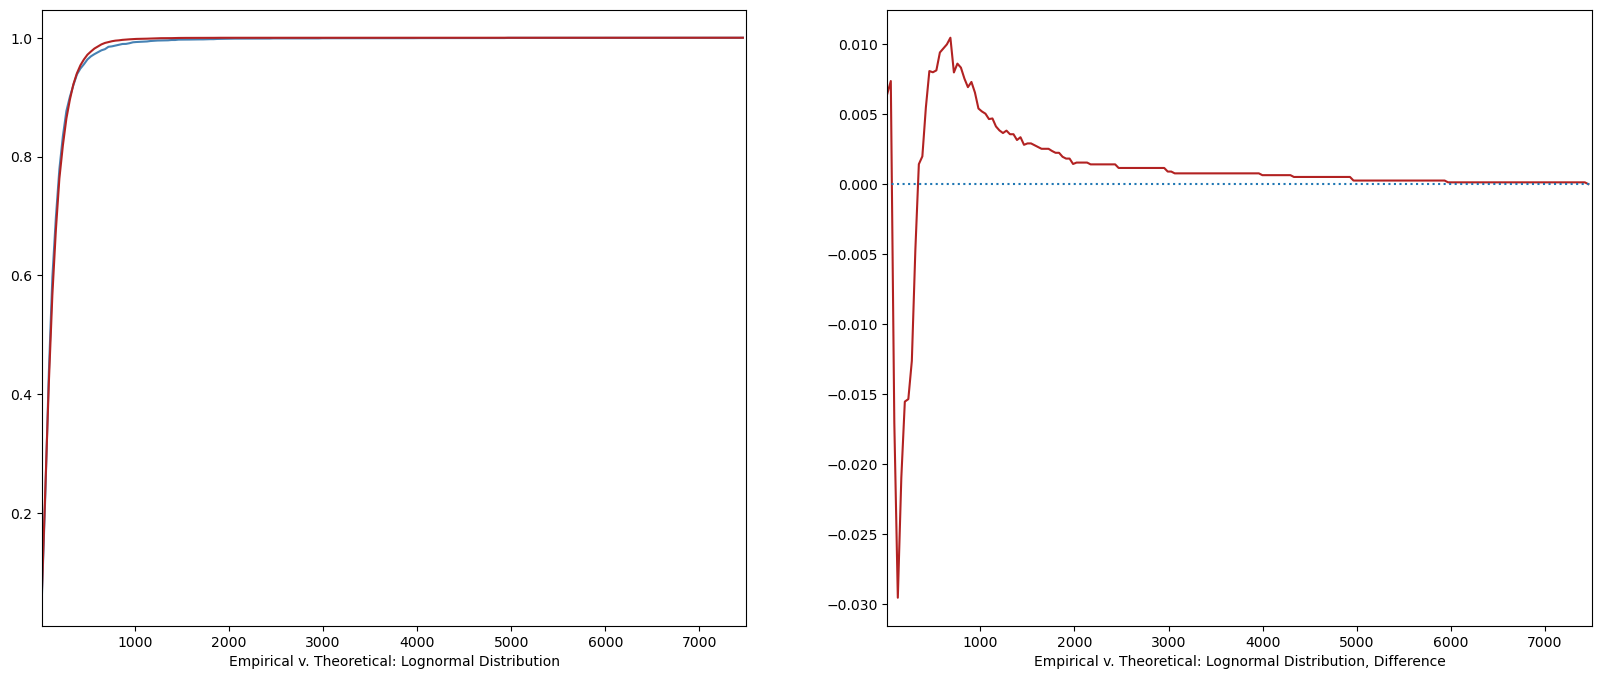

In [160]:
figure = plt.figure(figsize=(20, 8))

price_mn = np.min(price)
price_mx = np.max(price)
mean = np.mean(price)
std = np.std(price)

axes = figure.add_subplot(1, 2, 1)

values, base = np.histogram(price, bins=201, density=True)
cumulative = np.cumsum(values*(base[1:] - base[:-1]))
axes.plot(base[:-1], cumulative, color="steelblue")
axes.set_xlim((price_mn, price_mx))

values2, base2 = np.histogram(lognorm.rvs(s=sigma, loc=0, scale=np.exp(mu), size=10000), bins=base, density=True)
cumulative2 = np.cumsum(values2*(base2[1:] - base2[:-1]))
axes.plot(base[:-1], cumulative2, color="firebrick")
axes.set_xlim((price_mn, price_mx))
axes.set_xlabel("Empirical v. Theoretical: Lognormal Distribution")

axes = figure.add_subplot(1, 2, 2)

differences = cumulative2 - cumulative
axes.plot(base[:-1], differences, color='firebrick')
axes.set_xlim((price_mn, price_mx))
axes.hlines(0, 0, 14000, linestyles="dotted")
axes.set_xlabel("Empirical v. Theoretical: Lognormal Distribution, Difference")

plt.show()
plt.close()

The model clearly overestimates probabilities at some points and underestimates at others, but overall its cumulative distribution is generally less than 1 percentage point away from the empirical distribution. The main weakness is around price 100.

## Final Model

In [161]:
# Query the listings table in airbnb.db and convert the listings table to dataframe
vwListings = pd.read_sql('SELECT * FROM most_recent_listings', connection)

In [162]:
## convert price to numeric
vwListings['price'] = vwListings['price'].str.replace(',','',regex=False)
vwListings['price'] = vwListings['price'].str.strip('$').astype('float')

In [163]:
## STEVE: host_reponse_rate, host_acceptance_rate - fillna ('') with 0
# Create room_type_mod grouping hotel rooms together
vwListings['room_type_mod'] = vwListings['room_type']
vwListings.loc[vwListings['property_type'].isin(['Room in hotel', 'Room in boutique hotel',
        'Private room in bed and breakfast']), 'room_type_mod'] = 'Hotel room'

# Drop the listings having price = 0
vwListings.drop(vwListings.loc[vwListings['price']==0].index, inplace=True)

# Drop the unavailable listings
vwListings.drop(vwListings.loc[vwListings['has_availability']=='f'].index, inplace=True)
vwListings = vwListings.reset_index(drop=True)

# Replace null reviews_per_month = 0
vwListings['reviews_per_month'] = vwListings['reviews_per_month'].replace({'': 0})

# Drop 2 listings having over 31 reviews per month
vwListings.drop(vwListings.loc[vwListings['reviews_per_month'] > 31].index, inplace=True)
vwListings = vwListings.reset_index(drop=True)

# Replace null year in host_since by the most common value 2019-09-13
vwListings['host_since'] = vwListings['host_since'].replace({'': '2019-09-13'})
vwListings['host_since'] = pd.to_datetime(vwListings['host_since'])

# Replace null value by 'N/A' in host_response_time
vwListings['host_response_time'] = vwListings['host_response_time'].replace({'': 'N/A'})

# Replace N/A value in host_response_rate = 0
vwListings['host_response_rate'] = vwListings['host_response_rate'].str.replace('N/A', '0%')
vwListings['host_response_rate'] = vwListings['host_response_rate'].str.replace('%', '')
vwListings['host_response_rate'] = pd.to_numeric(vwListings['host_response_rate'])
vwListings['host_response_rate'] = vwListings['host_response_rate'].fillna(0)

# Replace N/A value in host_acceptance_rate = 0
vwListings['host_acceptance_rate'] = vwListings['host_acceptance_rate'].str.replace('N/A', '0%')
vwListings['host_acceptance_rate'] = vwListings['host_acceptance_rate'].str.replace('%', '')
vwListings['host_acceptance_rate'] = pd.to_numeric(vwListings['host_acceptance_rate'])
vwListings['host_acceptance_rate'] = vwListings['host_acceptance_rate'].fillna(0)

# Replace null value by 'f' in host_is_superhost
vwListings['host_is_superhost'] = vwListings['host_is_superhost'].replace({'': 'f'})

# Replace null value by 'f' in host_verifications
vwListings['host_verifications'] = vwListings['host_verifications'].replace({'': 'f'})

# Replace null value by 'f' in host_has_profile_pic
vwListings['host_has_profile_pic'] = vwListings['host_has_profile_pic'].replace({'': 'f'})

# Replace null value by 'f' in host_identity_verified
vwListings['host_identity_verified'] = vwListings['host_identity_verified'].replace({'': 'f'})

Next, we will clean the bedrooms variable. We will follow the rules below:
- If the value of the bedrooms variable is null and the value of the beds variable is not null, bedrooms will be equal to the value of beds.
- If the value of the beds variable is null and the value of the bedrooms variable is not null, beds will be equal to the value of bedrooms.
- Otherwise, both of the variables will be equal the mean of corresponding variable.

In [164]:
vwListings.loc[(vwListings['bedrooms'] == '')&(vwListings['beds'] == ''), ['bedrooms', 'beds']] = [2, 2]
vwListings.loc[vwListings['bedrooms'] == '', 'bedrooms'] = vwListings.loc[vwListings['bedrooms'] == '', 'beds']
vwListings.loc[vwListings['beds'] == '', 'beds'] = vwListings.loc[vwListings['beds'] == '', 'bedrooms']

vwListings['bedrooms'] = pd.to_numeric(vwListings['bedrooms'])
vwListings['beds'] = pd.to_numeric(vwListings['beds'])

In [165]:
vwListings.loc[vwListings['bathrooms_text'] == '0 shared baths', 'bathrooms_text'] = \
    vwListings.loc[vwListings['bathrooms_text'] == '0 shared baths', 'bedrooms'].astype('str') + ' baths'
vwListings['bathrooms_text'] = vwListings['bathrooms_text'].replace(
    ['0 baths', 'Half-bath', 'Private half-bath', 'Shared half-bath', ''], '1 bathroom')

In [166]:
# Extract the number of bathrooms from bathroom_text.
vwListings['bathroom_numbers'] = vwListings['bathrooms_text'].str.split().str.get(0)
vwListings['bathroom_numbers'] = pd.to_numeric(vwListings['bathroom_numbers'])

In [167]:
# This step is to prepare for One Hot Encodings
for i in range(len(vwListings['host_response_time'])):
    if 'within an hour' in vwListings['host_response_time'][i]:
        vwListings['host_response_time'][i] = 'within_an_hour'
    elif 'N/A' in vwListings['host_response_time'][i]:
        vwListings['host_response_time'][i] = 'na'
    elif 'within a few hours' in vwListings['host_response_time'][i]:
        vwListings['host_response_time'][i] = 'within_a_few_hours'
    elif 'within a day' in vwListings['host_response_time'][i]:
        vwListings['host_response_time'][i] = 'within_a_day'
    elif 'a few days or more' in vwListings['host_response_time'][i]:
        vwListings['host_response_time'][i] = 'a_few_days_or_more'

        
for i in range(len(vwListings['room_type_mod'])):
    if 'Entire home/apt' in vwListings['room_type_mod'][i]:
        vwListings['room_type_mod'][i] = 'entire_home_apt'
    elif 'Private room' in vwListings['room_type_mod'][i]:
        vwListings['room_type_mod'][i] = 'private_room'
    elif 'Hotel room' in vwListings['room_type_mod'][i]:
        vwListings['room_type_mod'][i] = 'hotel_room'
    elif 'Shared room' in vwListings['room_type_mod'][i]:
        vwListings['room_type_mod'][i] = 'shared_room'

In [168]:
# Convert the all the review scores to numeric
vwListings['review_scores_rating'] = pd.to_numeric(vwListings['review_scores_rating'])
vwListings['review_scores_accuracy'] = pd.to_numeric(vwListings['review_scores_accuracy'])
vwListings['review_scores_cleanliness'] = pd.to_numeric(vwListings['review_scores_cleanliness'])
vwListings['review_scores_checkin'] = pd.to_numeric(vwListings['review_scores_checkin'])
vwListings['review_scores_communication'] = pd.to_numeric(vwListings['review_scores_communication'])
vwListings['review_scores_location'] = pd.to_numeric(vwListings['review_scores_location'])
vwListings['review_scores_value'] = pd.to_numeric(vwListings['review_scores_value'])

In [169]:
## fill review_scores na with the mean
for col in vwListings.columns:
    if col.startswith('review_scores'):
        x = vwListings[col]
        vwListings[col] = vwListings[col].fillna(x.mean())

In [170]:
#  the coordinates (latitude, longtitute of a place from google map )
smithsonian_lat = 38.8889532077163
smithsonian_long = -77.0259992316524
lincoln_memorial_lat = 38.8893771334115
lincoln_memorial_long = -77.0501761044084
capitol_lat = 38.8900557831996
capttol_long = -77.0090290467363
white_house_lat = 38.9103145107623
white_house_long = -77.0221504467353
library_of_congress_lat = 38.8888008852652
library_of_congress_long = -77.0047082755724
nationals_park_lat = 38.8731981381059
nationals_park_long = -77.0074329
national_zoo_lat = 38.9294590679026
national_zoo_long = -77.0492384835061
union_station_lat = 38.8973065709087
union_station_long = -77.00629767372
mcpherson_sq_lat = 38.9028682064423
mcpherson_sq_long = -77.0324745881233

In [171]:
# distance unit = miles
vwListings["distance_smithsonian"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(smithsonian_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(smithsonian_lat))
                                            *np.cos(np.radians(smithsonian_long-vwListings["longitude"])) )*3963*1.15077945

In [172]:
vwListings["distance_lincoln"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(lincoln_memorial_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(lincoln_memorial_lat))
                                            *np.cos(np.radians(lincoln_memorial_long-vwListings["longitude"])) )*3963*1.15077945

In [173]:
vwListings["distance_capitol"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(capitol_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(capitol_lat))
                                            *np.cos(np.radians(capttol_long-vwListings["longitude"])) )*3963*1.15077945

In [174]:
vwListings["distance_white_house"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(white_house_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(white_house_lat))
                                            *np.cos(np.radians(white_house_long-vwListings["longitude"])) )*3963*1.15077945

In [175]:
vwListings["distance_white_house"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(white_house_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(white_house_lat))
                                            *np.cos(np.radians(white_house_long-vwListings["longitude"])) )*3963*1.15077945

In [176]:
vwListings["distance_nationals_park"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(nationals_park_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(nationals_park_lat))
                                            *np.cos(np.radians(nationals_park_long-vwListings["longitude"])) )*3963*1.15077945

In [177]:
vwListings["distance_national_zoo"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(national_zoo_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(national_zoo_lat))
                                            *np.cos(np.radians(national_zoo_long-vwListings["longitude"])) )*3963*1.15077945

In [178]:
vwListings["distance_railway"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(union_station_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(union_station_lat))
                                            *np.cos(np.radians(union_station_long-vwListings["longitude"])) )*3963*1.15077945

In [193]:
vwListings["distance_mcpherson"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(mcpherson_sq_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(mcpherson_sq_lat))
                                            *np.cos(np.radians(mcpherson_sq_long-vwListings["longitude"])) )*3963*1.15077945

In [194]:
vwListings["distance_library_congress"] = np.arccos(np.sin(np.radians(vwListings["latitude"]))
                                            * np.sin(np.radians(library_of_congress_lat)) 
                                            + np.cos(np.radians(vwListings["latitude"]))
                                            *np.cos(np.radians(library_of_congress_lat))
                                            *np.cos(np.radians(library_of_congress_long-vwListings["longitude"])))*3963*1.15077945

We will convert one hot encodings for the following categorical variables host_response_time, host_is_superhost, host_has_profile_pic, host_identity_verified, room_type_mod

In [180]:
vwListings = pd.concat([vwListings, pd.get_dummies(vwListings['host_response_time'], prefix='response_time', prefix_sep='_')], axis=1)
vwListings = pd.concat([vwListings, pd.get_dummies(vwListings['host_is_superhost'], prefix='superhost', prefix_sep='_')], axis=1)
vwListings = pd.concat([vwListings, pd.get_dummies(vwListings['host_identity_verified'], prefix='identity_verified', prefix_sep='_')], axis=1)
vwListings = pd.concat([vwListings, pd.get_dummies(vwListings['host_has_profile_pic'], prefix='profile', prefix_sep='_')], axis=1)
vwListings = pd.concat([vwListings, pd.get_dummies(vwListings['room_type_mod'])], axis=1)
vwListings = pd.concat([vwListings, pd.get_dummies(vwListings['instant_bookable'], prefix='instant_bookable', prefix_sep='_')], axis=1) # ADDED

In [181]:
vwListings.loc[(vwListings['host_id']==294545484)&(vwListings['room_type_mod']=='private_room'), 'bedrooms'] = 1
vwListings.loc[vwListings['maximum_nights'] < vwListings['minimum_nights'], 'maximum_nights'] = vwListings.loc[
    vwListings['maximum_nights'] < vwListings['minimum_nights'], 'minimum_nights']

In [182]:
vwListings.loc[vwListings['maximum_nights'] > 1125, 'maximum_nights'] = 1125

In [183]:
base_date = pd.Timestamp('2023-03-19')

In [184]:
vwListings['last_review'] = pd.to_datetime(vwListings['last_review'])
vwListings['days_since_last_review'] = vwListings['last_review'].apply(lambda x: (base_date - x).days)
vwListings.loc[vwListings['days_since_last_review'].isna(), 'days_since_last_review'] =\
    vwListings['days_since_last_review'].mean()

In [185]:
vwListings['days_since_host_joined'] = vwListings['host_since'].apply(lambda x: (base_date - x).days)

In [186]:
vwListings['log_minimum_nights'] = vwListings['minimum_nights'].apply(math.log)
vwListings['log_days_since_last_review'] = vwListings['days_since_last_review'].apply(math.log)

In [187]:
vwListings['beds_sq'] = vwListings['beds'].apply(lambda x: x ** 2)
vwListings['bedrooms_sq'] = vwListings['bedrooms'].apply(lambda x: x ** 2)
vwListings['bathroom_numbers_sq'] = vwListings['bathroom_numbers'].apply(lambda x: x ** 2)
vwListings['review_scores_rating_sq'] = vwListings['review_scores_rating'].apply(lambda x: x ** 2)
vwListings['review_scores_cleanliness_sq'] = vwListings['review_scores_cleanliness'].apply(lambda x: x ** 2)
vwListings['entire_home_apt_sq'] = vwListings['entire_home_apt'].apply(lambda x: x ** 2)
vwListings['review_scores_location_sq'] = vwListings['review_scores_location'].apply(lambda x: x ** 2)
vwListings['host_response_rate_sq'] = vwListings['host_response_rate'].apply(lambda x: x ** 2)
vwListings['host_acceptance_rate_sq'] = vwListings['host_acceptance_rate'].apply(lambda x: x ** 2)

In [195]:
np.random.seed(1432897)
model4 = ("price ~ beds_sq + bedrooms_sq + bathroom_numbers_sq + log_minimum_nights + accommodates \
        + entire_home_apt_sq + hotel_room + private_room + response_time_within_a_day + instant_bookable_t \
        + number_of_reviews + review_scores_rating_sq + review_scores_cleanliness_sq + identity_verified_t \
        + review_scores_accuracy + host_response_rate_sq + host_acceptance_rate_sq \
        + review_scores_location_sq + log_days_since_last_review + superhost_t \
        + distance_white_house + distance_capitol + distance_nationals_park + distance_library_congress \
        + distance_railway + distance_national_zoo + distance_smithsonian + distance_mcpherson")
result4 = models.bootstrap_linear_regression(model4, data=vwListings)
models.describe_bootstrap_lr(result4, sd=4)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-164.0985,-221.7215,-91.0673
beds_sq,$\beta_{1}$,1.2022,-1.1698,3.1710
bedrooms_sq,$\beta_{2}$,8.5848,3.9488,16.2436
bathroom_numbers_sq,$\beta_{3}$,6.6168,2.1930,11.0136
log_minimum_nights,$\beta_{4}$,-16.7198,-20.5950,-11.1838
accommodates,$\beta_{5}$,13.3484,-1.1717,29.0528
entire_home_apt_sq,$\beta_{6}$,108.6368,61.4360,149.5148
hotel_room,$\beta_{7}$,183.0778,134.8009,220.5558
private_room,$\beta_{8}$,69.7592,38.4673,98.1431
